In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import mplcatppuccin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('styler.format.precision', 3)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

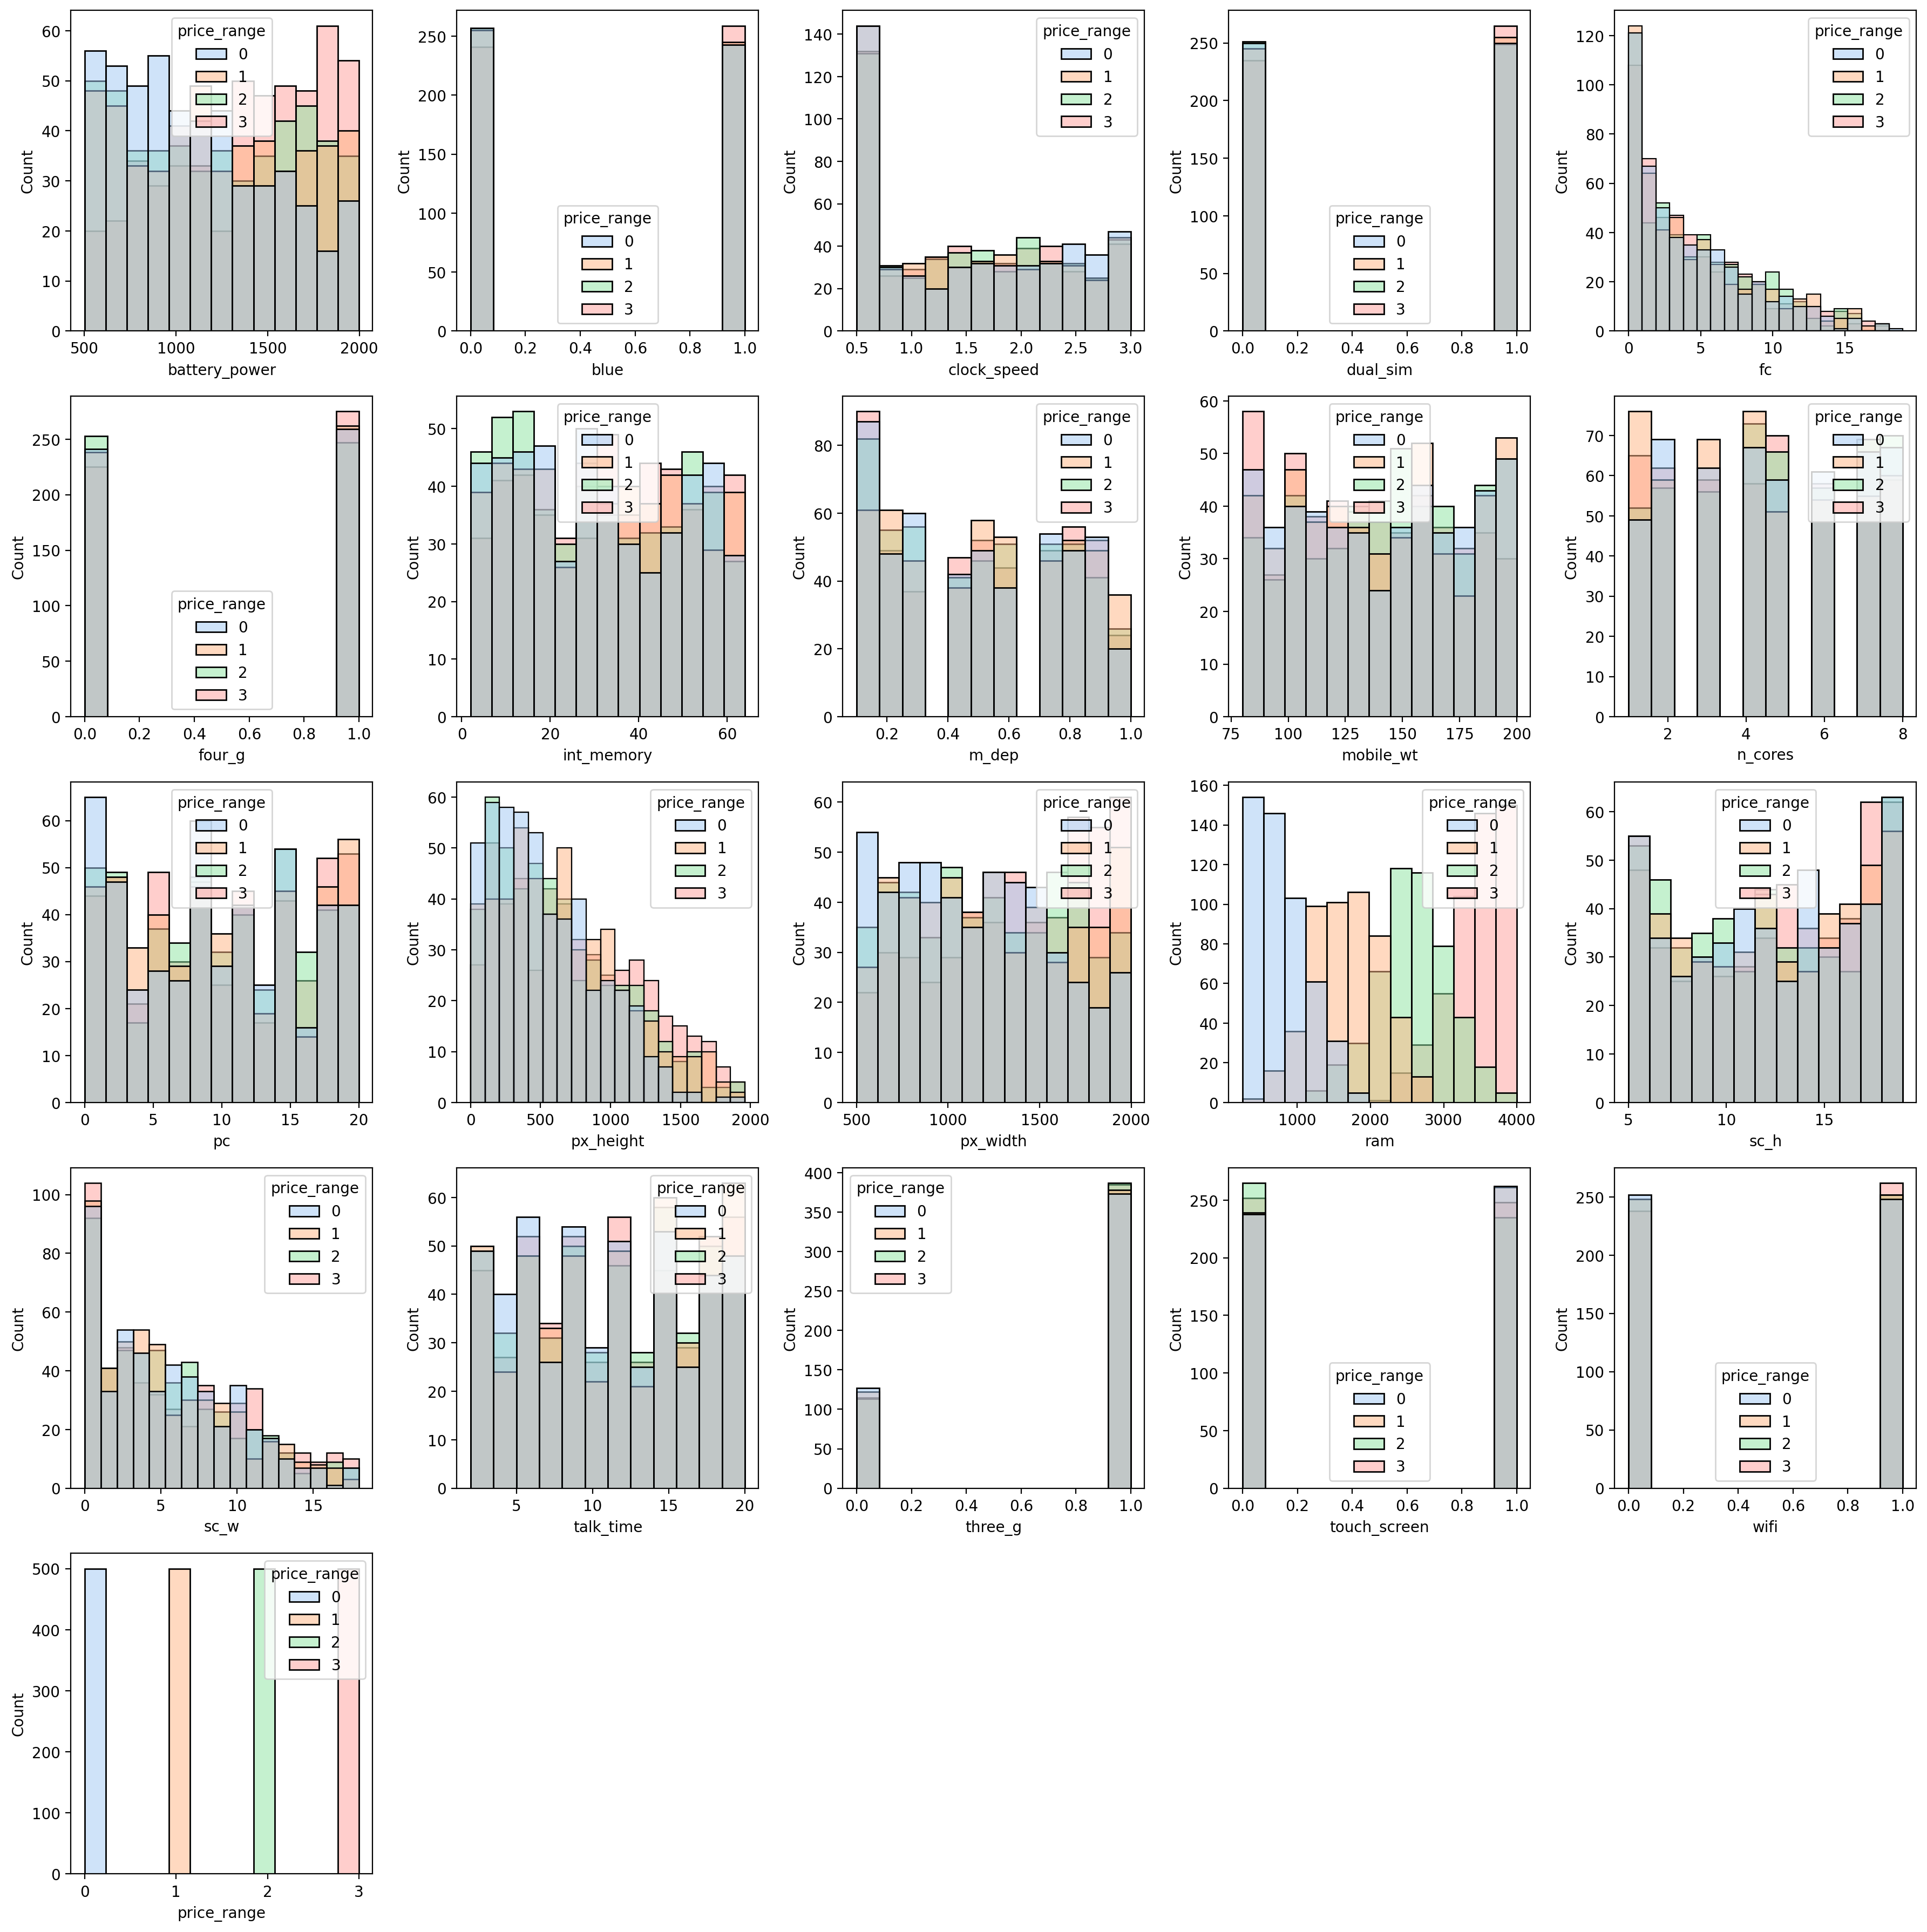

In [3]:
nrows=5
ncols=5

plt.figure(figsize=(18,18))
for i, col in enumerate(train_df.columns.to_list()):
    ax = plt.subplot(nrows,ncols,i+1)
    sns.histplot(x=train_df[col], ax=ax, hue=train_df['price_range'], palette='pastel')

plt.tight_layout()

In [4]:
cat_cols = ['blue', 'dual_sim', 'four_g', 'pc', 'three_g', 'touch_screen', 'wifi']

for cat in cat_cols:
    try:
        train_df[cat] = train_df[cat].astype('category')
        test_df[cat] = test_df[cat].astype('category')
    except:
        pass



In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  2000 non-null   int64   
 1   blue           2000 non-null   category
 2   clock_speed    2000 non-null   float64 
 3   dual_sim       2000 non-null   category
 4   fc             2000 non-null   int64   
 5   four_g         2000 non-null   category
 6   int_memory     2000 non-null   int64   
 7   m_dep          2000 non-null   float64 
 8   mobile_wt      2000 non-null   int64   
 9   n_cores        2000 non-null   int64   
 10  pc             2000 non-null   category
 11  px_height      2000 non-null   int64   
 12  px_width       2000 non-null   int64   
 13  ram            2000 non-null   int64   
 14  sc_h           2000 non-null   int64   
 15  sc_w           2000 non-null   int64   
 16  talk_time      2000 non-null   int64   
 17  three_g        2000 non-null   ca

In [6]:
num_values = train_df.select_dtypes(exclude='category')
num_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   clock_speed    2000 non-null   float64
 2   fc             2000 non-null   int64  
 3   int_memory     2000 non-null   int64  
 4   m_dep          2000 non-null   float64
 5   mobile_wt      2000 non-null   int64  
 6   n_cores        2000 non-null   int64  
 7   px_height      2000 non-null   int64  
 8   px_width       2000 non-null   int64  
 9   ram            2000 non-null   int64  
 10  sc_h           2000 non-null   int64  
 11  sc_w           2000 non-null   int64  
 12  talk_time      2000 non-null   int64  
 13  price_range    2000 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 218.9 KB


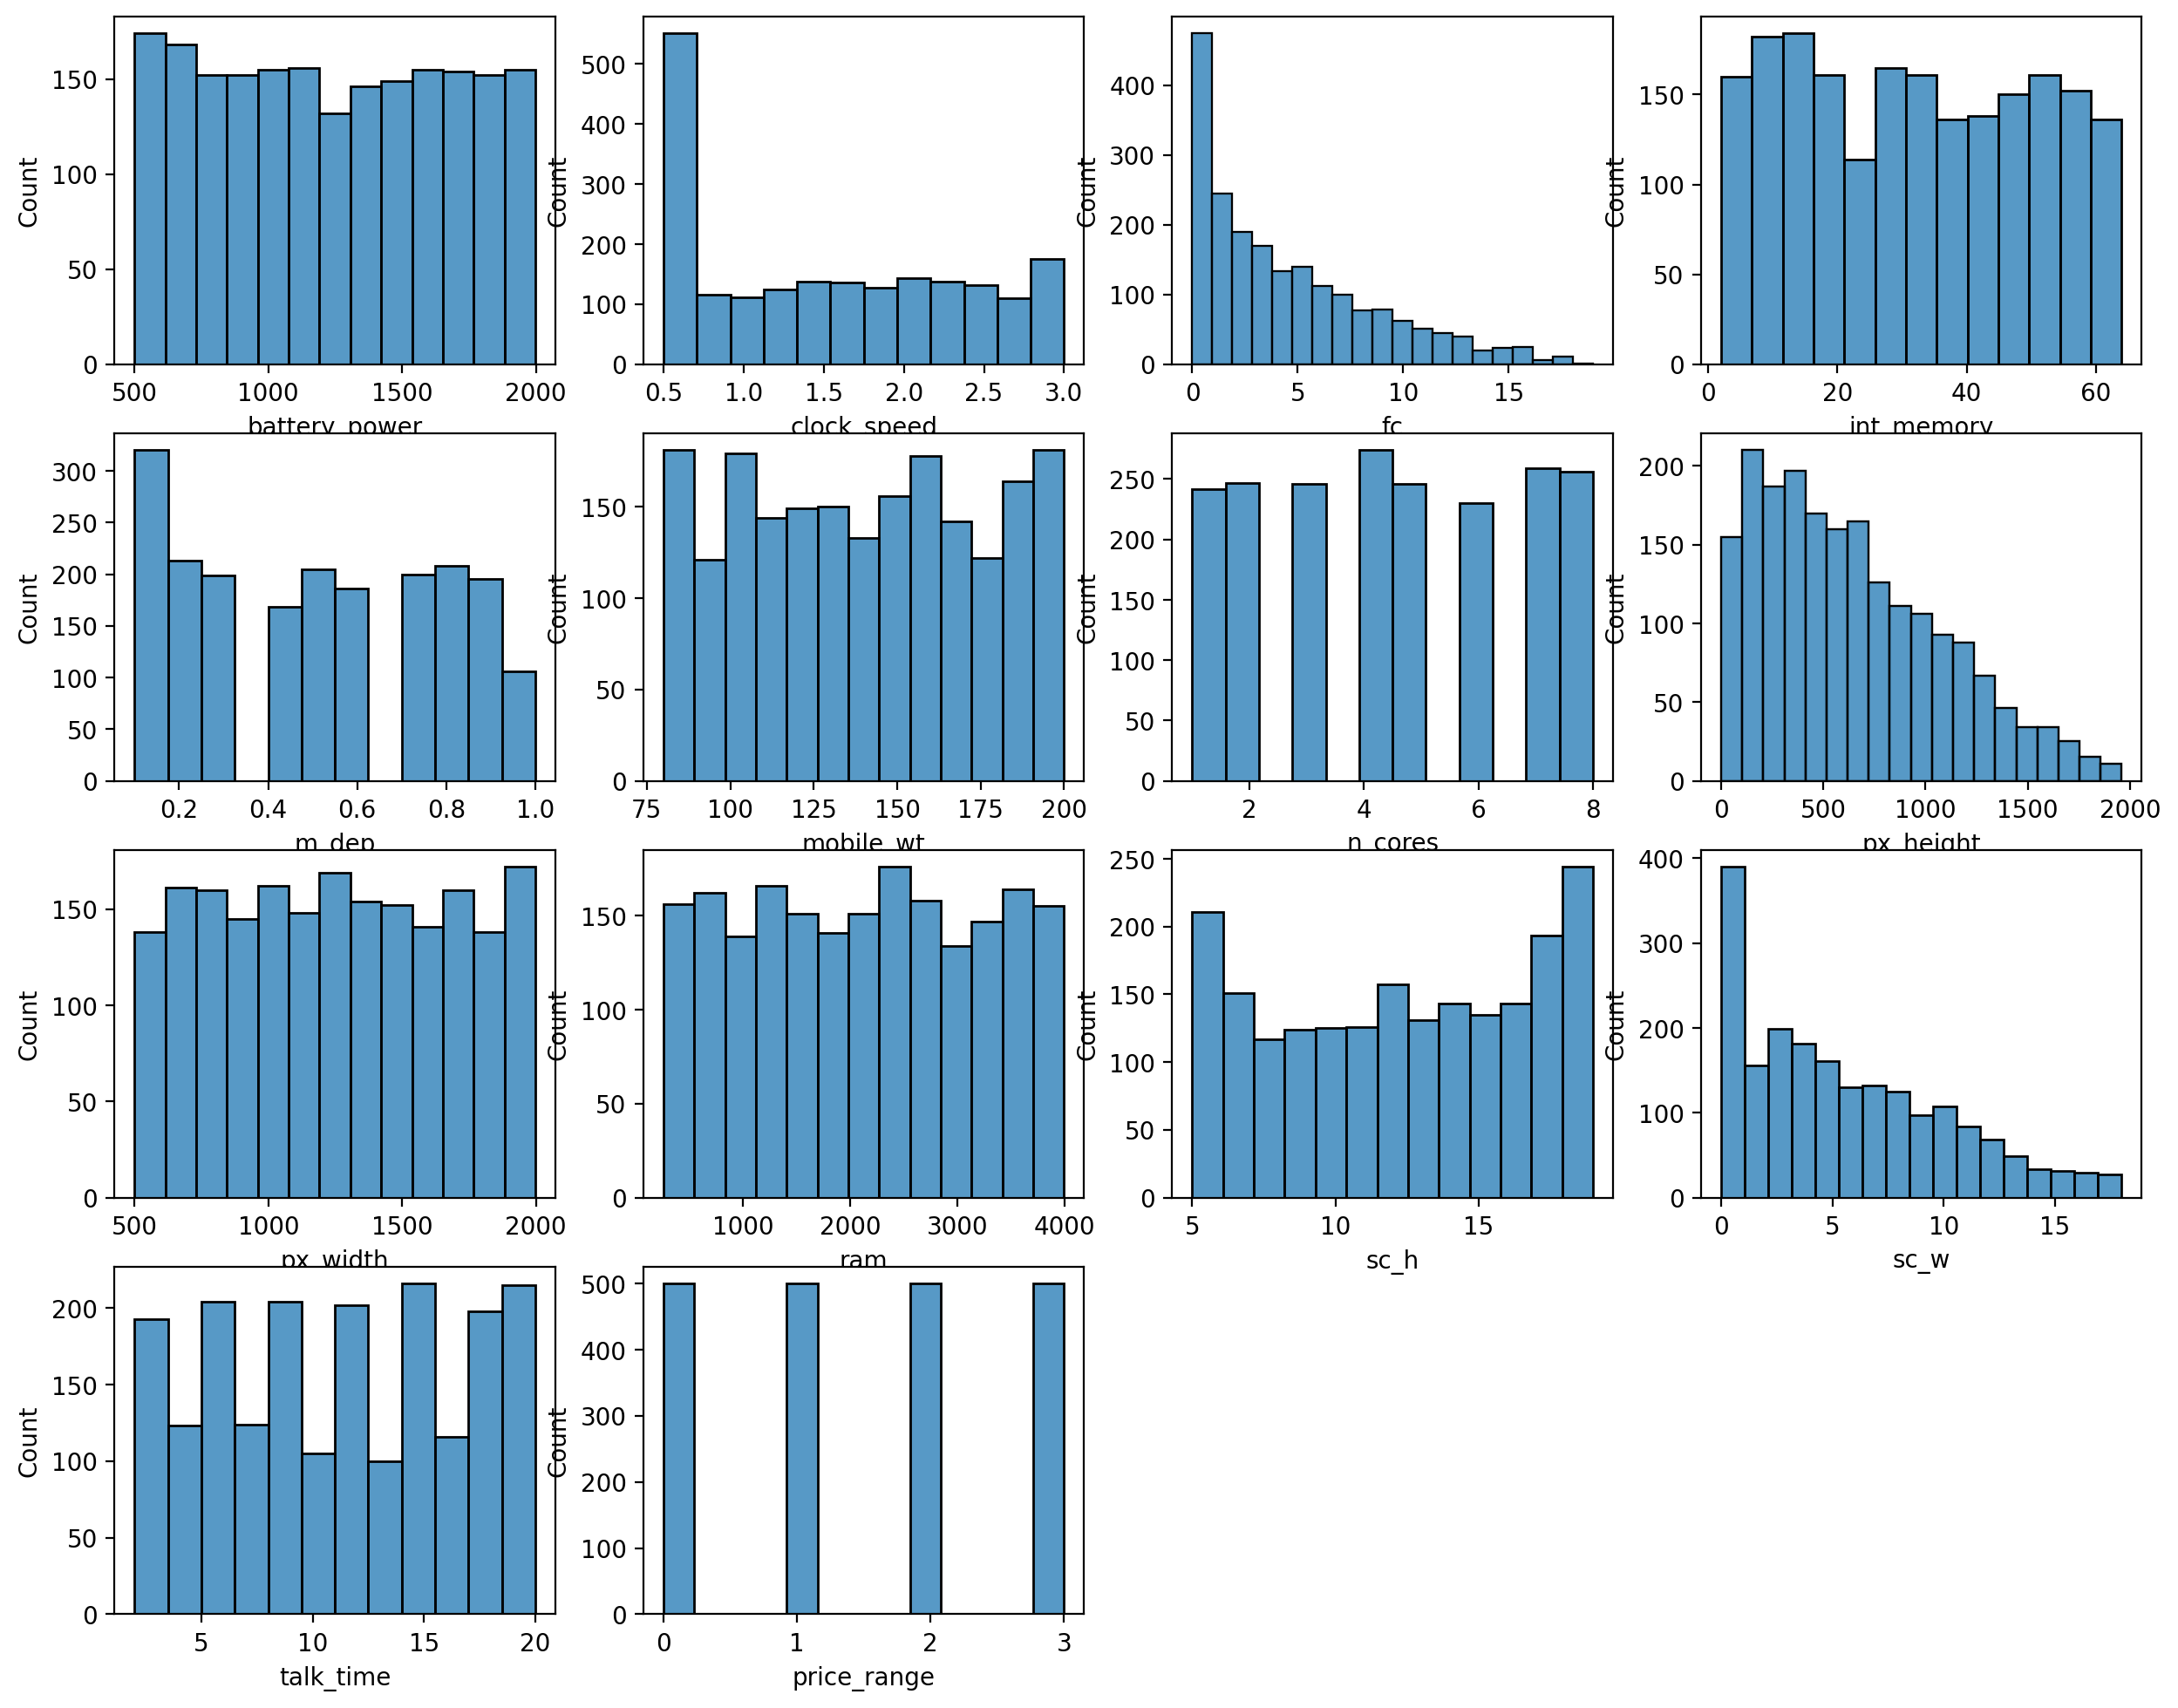

In [7]:
plt.figure(figsize=(15,15))

for i, col in enumerate(num_values.columns.to_list()):
    ax = plt.subplot(5,4, i+1)
    sns.histplot(x=num_values[col], ax=ax)

In [8]:
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

log_fun = FunctionTransformer(func=np.log1p,
                              inverse_func=np.expm1,
                              feature_names_out='one-to-one',
                              )

std_scaler = StandardScaler()
norm_scaler = Normalizer()

pip_log = Pipeline(steps=[('log', log_fun), ('std', std_scaler)])
pip_norm = Pipeline(steps=[('norm', norm_scaler), ('std', std_scaler)])

check_df = pd.DataFrame(data=pip_norm.fit_transform(num_values),
                        columns=num_values.columns)

In [9]:
from sklearn.model_selection import train_test_split, cross_validate

X = train_df.drop('price_range', axis=1)
y = train_df['price_range']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=1600, stratify=y, shuffle=True)

print(X_train.shape)
print(X_val.shape)

(1600, 20)
(400, 20)


In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.compose import ColumnTransformer

In [11]:
num_cols = num_values.drop('price_range', axis=1).columns.to_list()
num_cols

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [12]:

preprocessor = ColumnTransformer(
    transformers=[('pip', pip_log, num_cols)],
    remainder=OneHotEncoder(sparse_output=False),
    verbose_feature_names_out=False,
    n_jobs=-1
)

In [13]:
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB

rf_clf = Pipeline(steps=[('preprocessor', preprocessor), ('rf', RandomForestClassifier())])
gbc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('gbc', GradientBoostingClassifier())])
hgbc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('hgbc', HistGradientBoostingClassifier())])
abc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('abc', AdaBoostClassifier())])
etc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('etc', ExtraTreesClassifier())])
lr_clf = Pipeline(steps=[('preprocessor', preprocessor), ('lr', LogisticRegression())])
ridge_clf = Pipeline(steps=[('preprocessor', preprocessor), ('ridge', RidgeClassifier())])
sgd_clf = Pipeline(steps=[('preprocessor', preprocessor), ('sgd', SGDClassifier())])
nn_clf = Pipeline(steps=[('preprocessor', preprocessor), ('nn', MLPClassifier(solver='sgd', max_iter=20000, activation='tanh'))])
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', xgb.XGBClassifier)])
xgbrf_clf = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', xgb.XGBRFClassifier)])
dt_clf = Pipeline(steps=[('preprocessor', preprocessor), ('dt', DecisionTreeClassifier())])
et_clf = Pipeline(steps=[('preprocessor', preprocessor), ('ext', ExtraTreeClassifier())])
catnb_clf = Pipeline(steps=[('preprocessor', preprocessor), ('cat_nb', CategoricalNB())])
gaunb_clf = Pipeline(steps=[('preprocessor', preprocessor), ('gnb', GaussianNB())])
mnb_clf = Pipeline(steps=[('preprocessor', preprocessor), ('mnb', MultinomialNB())])


In [14]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score

classifiers = [rf_clf, gbc_clf, hgbc_clf, abc_clf, etc_clf, lr_clf, ridge_clf, sgd_clf, nn_clf, xgb_clf, xgbrf_clf, dt_clf, et_clf, catnb_clf, gaunb_clf, mnb_clf]
names = ['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier',
         'AdaBoostClassifier', 'ExtraTreesClassifier', 'LogisticRegression', 'RidgeClassifier', 
         'SGDClassifier', 'MLPClassifier', 'XGBClassifier', 'XGBRFClassifier', 'DecisionTreeClassifier', 'ExtraTreeClassifier', 'CategoricalNB', 'GaussianNB', 'MultinomialNB']

results = {}
for name, clf in zip(names, classifiers):
    try:
        clf.fit(X_train, y_train)
        y_class = clf.predict(X_val)
        acc = accuracy_score(y_true=y_val, y_pred=y_class)
        f1 = f1_score(y_true=y_val, y_pred=y_class, average='weighted')
        precision = precision_score(y_true=y_val, y_pred=y_class, average='weighted')
        recall = recall_score(y_true=y_val, y_pred=y_class, average='weighted')
        roc = roc_auc_score(y_true=y_val, y_score=clf.predict_proba(X_val), average='weighted', multi_class='ovr')
        
        results[name] = {'F1':np.round(f1,3), 
                         'Accuracy':np.round(acc,3), 
                         'Precision':np.round(precision,3), 
                         'Recall':np.round(recall,3), 
                         'ROC-AUC':np.round(roc,3)
                         }
    except:
        pass

results_df = pd.DataFrame.from_dict(data=results, orient='index').sort_values(by='F1', ascending=False)

results_df


/Users/alejandrodelgado/kaggle_2/new_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,F1,Accuracy,Precision,Recall,ROC-AUC
HistGradientBoostingClassifier,0.930,0.930,0.932,0.930,0.991
GradientBoostingClassifier,0.923,0.922,0.925,0.922,0.989
MLPClassifier,0.896,0.895,0.899,0.895,0.986
LogisticRegression,0.881,0.880,0.885,0.880,0.984
RandomForestClassifier,0.867,0.868,0.870,0.868,0.974
DecisionTreeClassifier,0.841,0.840,0.845,0.840,0.893
ExtraTreesClassifier,0.792,0.792,0.793,0.792,0.939
AdaBoostClassifier,0.672,0.685,0.719,0.685,0.901
GaussianNB,0.554,0.552,0.564,0.552,0.821
ExtraTreeClassifier,0.464,0.462,0.465,0.462,0.642


In [15]:
from sklearn.model_selection import cross_validate

def fun_cross_validation(clf, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, cv=5):
    
    results = cross_validate(estimator=clf, X=X_train, y=y_train,
                             n_jobs=-1, scoring=['accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'],
                             cv=cv, return_train_score=True)
    
    results_df = pd.DataFrame.from_dict(data=results,
                                        orient='columns')
    
    cols = ['test_accuracy', 'train_accuracy', 'test_f1_weighted', 'train_f1_weighted',
            'test_roc_auc_ovr_weighted', 'train_roc_auc_ovr_weighted']
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    sns.lineplot(data=results_df, y=cols[0], x=results_df.index, ax=axs[0])
    sns.lineplot(data=results_df, y=cols[1], x=results_df.index, ax=axs[0])
    sns.lineplot(data=results_df, y=cols[2], x=results_df.index, ax=axs[1])
    sns.lineplot(data=results_df, y=cols[3], x=results_df.index, ax=axs[1])
    sns.lineplot(data=results_df, y=cols[4], x=results_df.index, ax=axs[2])
    sns.lineplot(data=results_df, y=cols[5], x=results_df.index, ax=axs[2])

    plt.tight_layout()
    
    return plt.show()


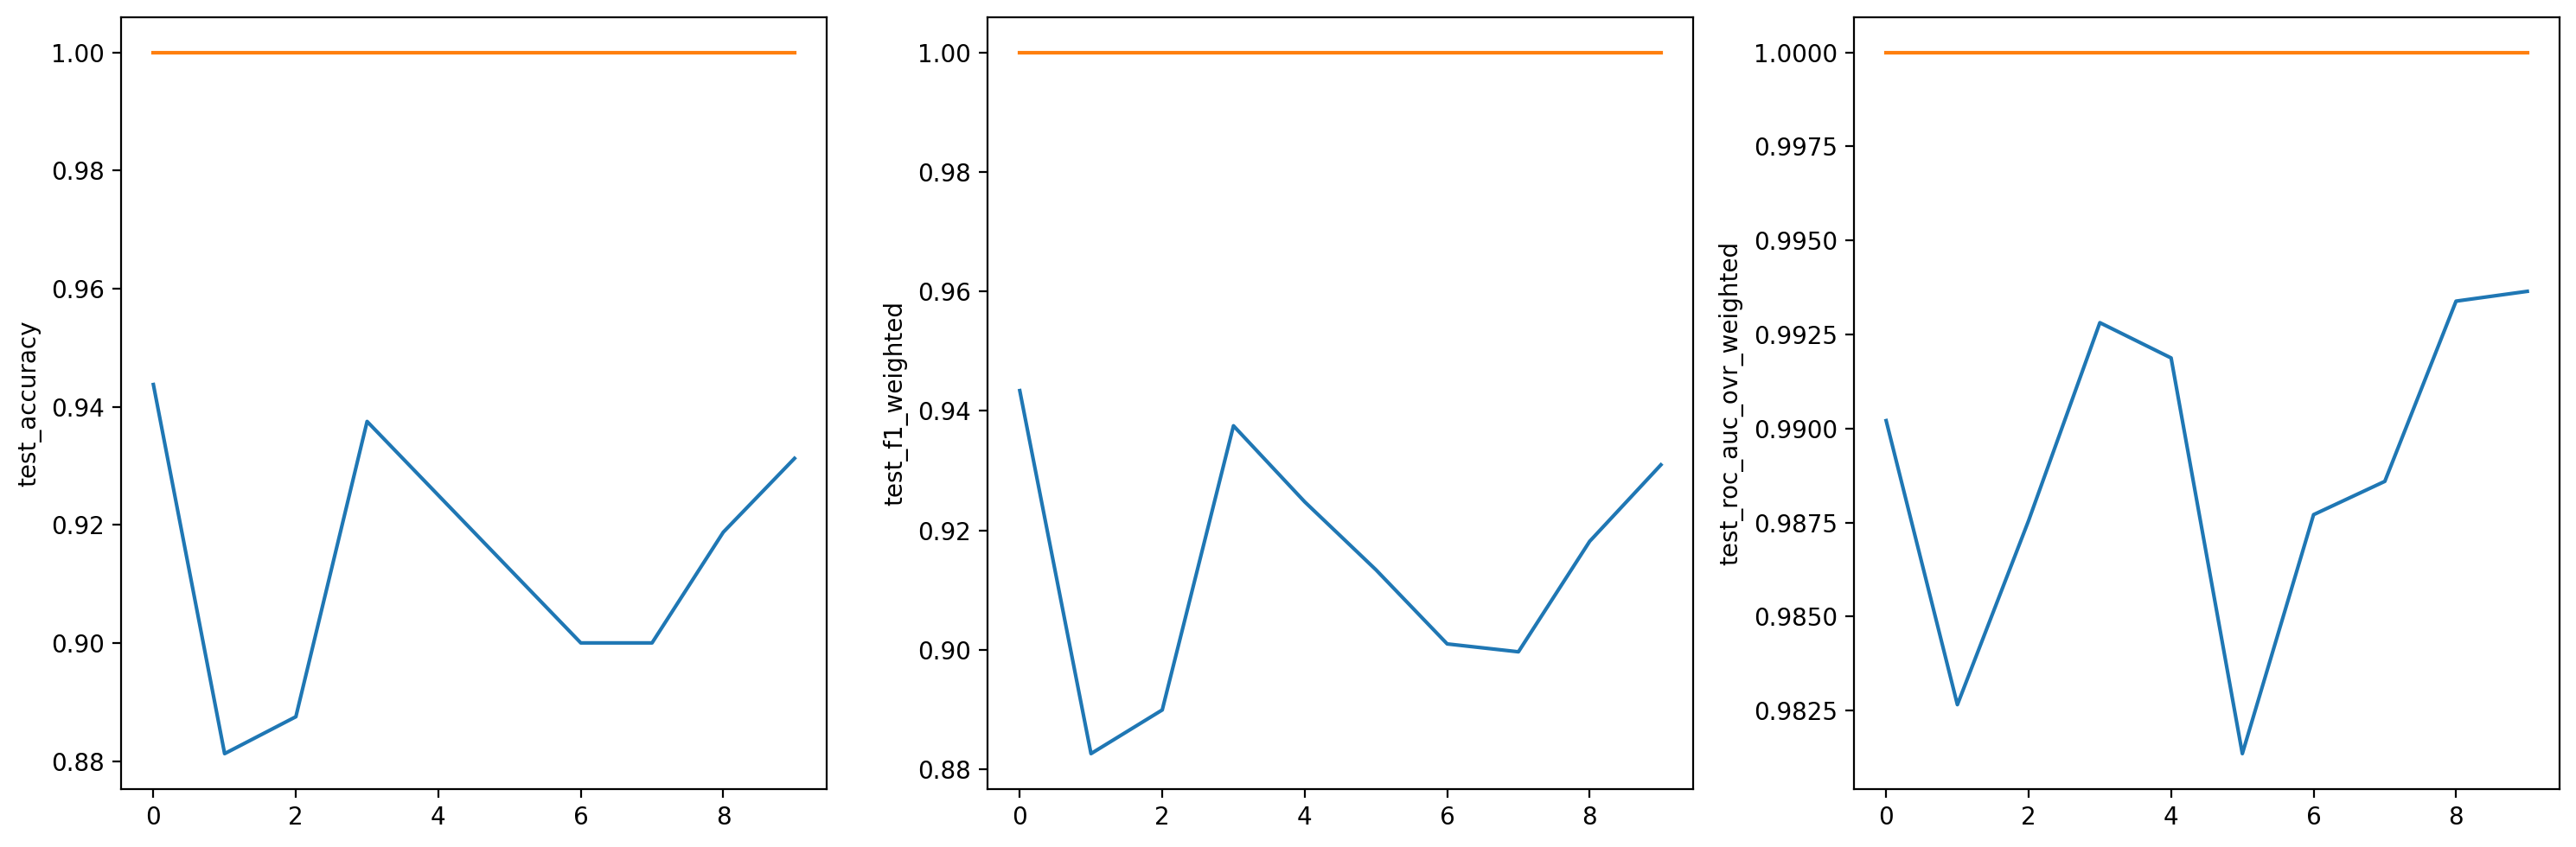

In [16]:
fun_cross_validation(hgbc_clf, cv=10)

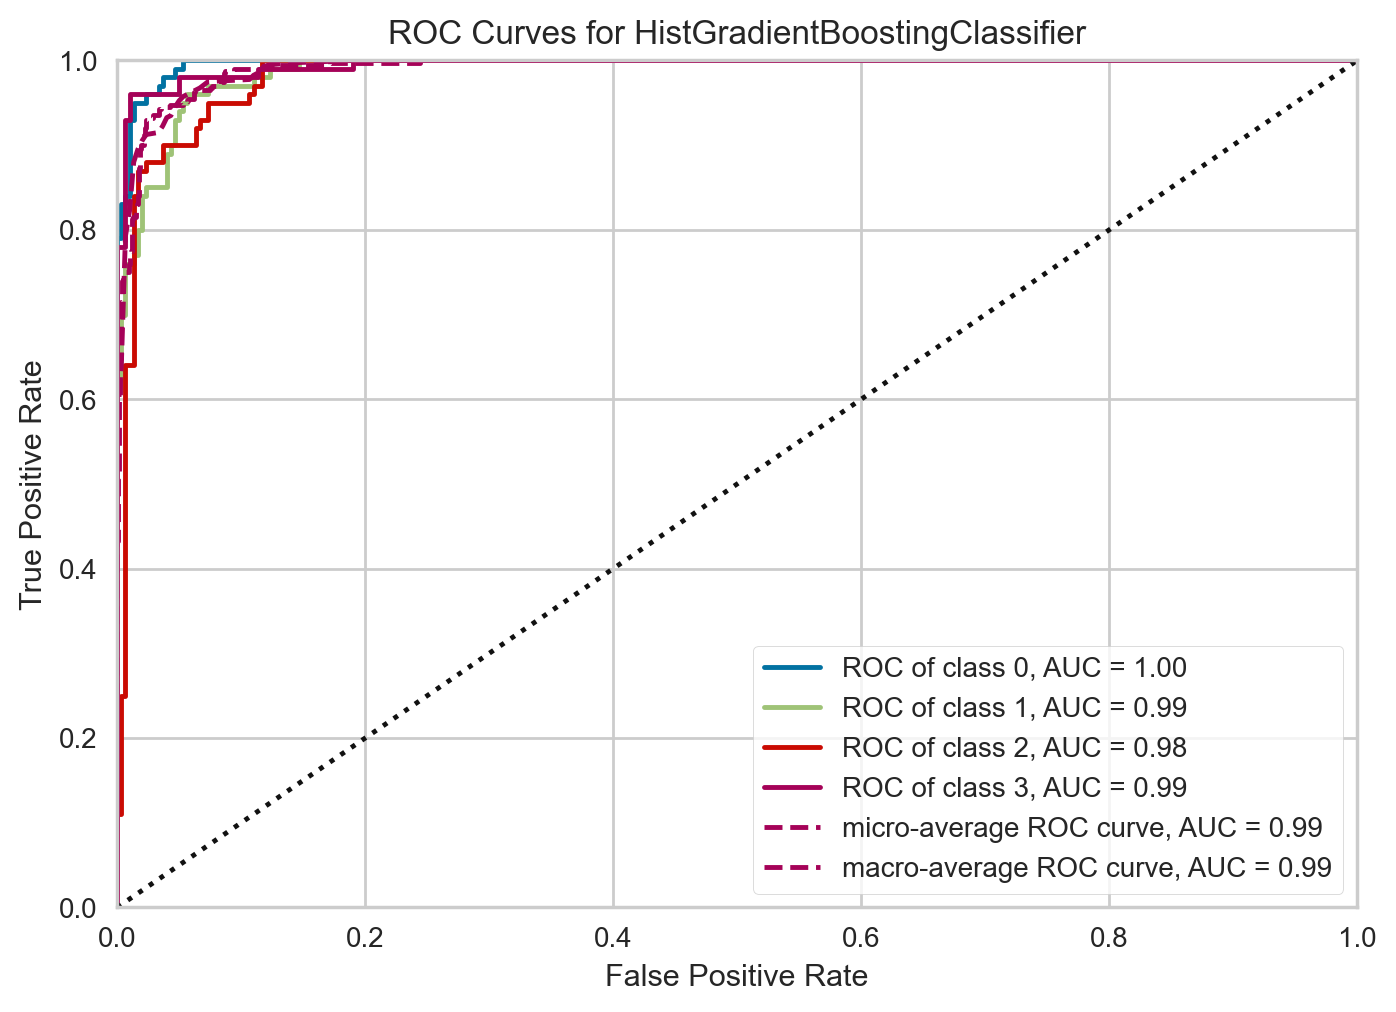

<Axes: title={'center': 'ROC Curves for HistGradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ClassPredictionError, DiscriminationThreshold

vis_roc = ROCAUC(hgbc_clf)

vis_roc.fit(X_train, y_train)
vis_roc.score(X_val, y_val)
vis_roc.show()

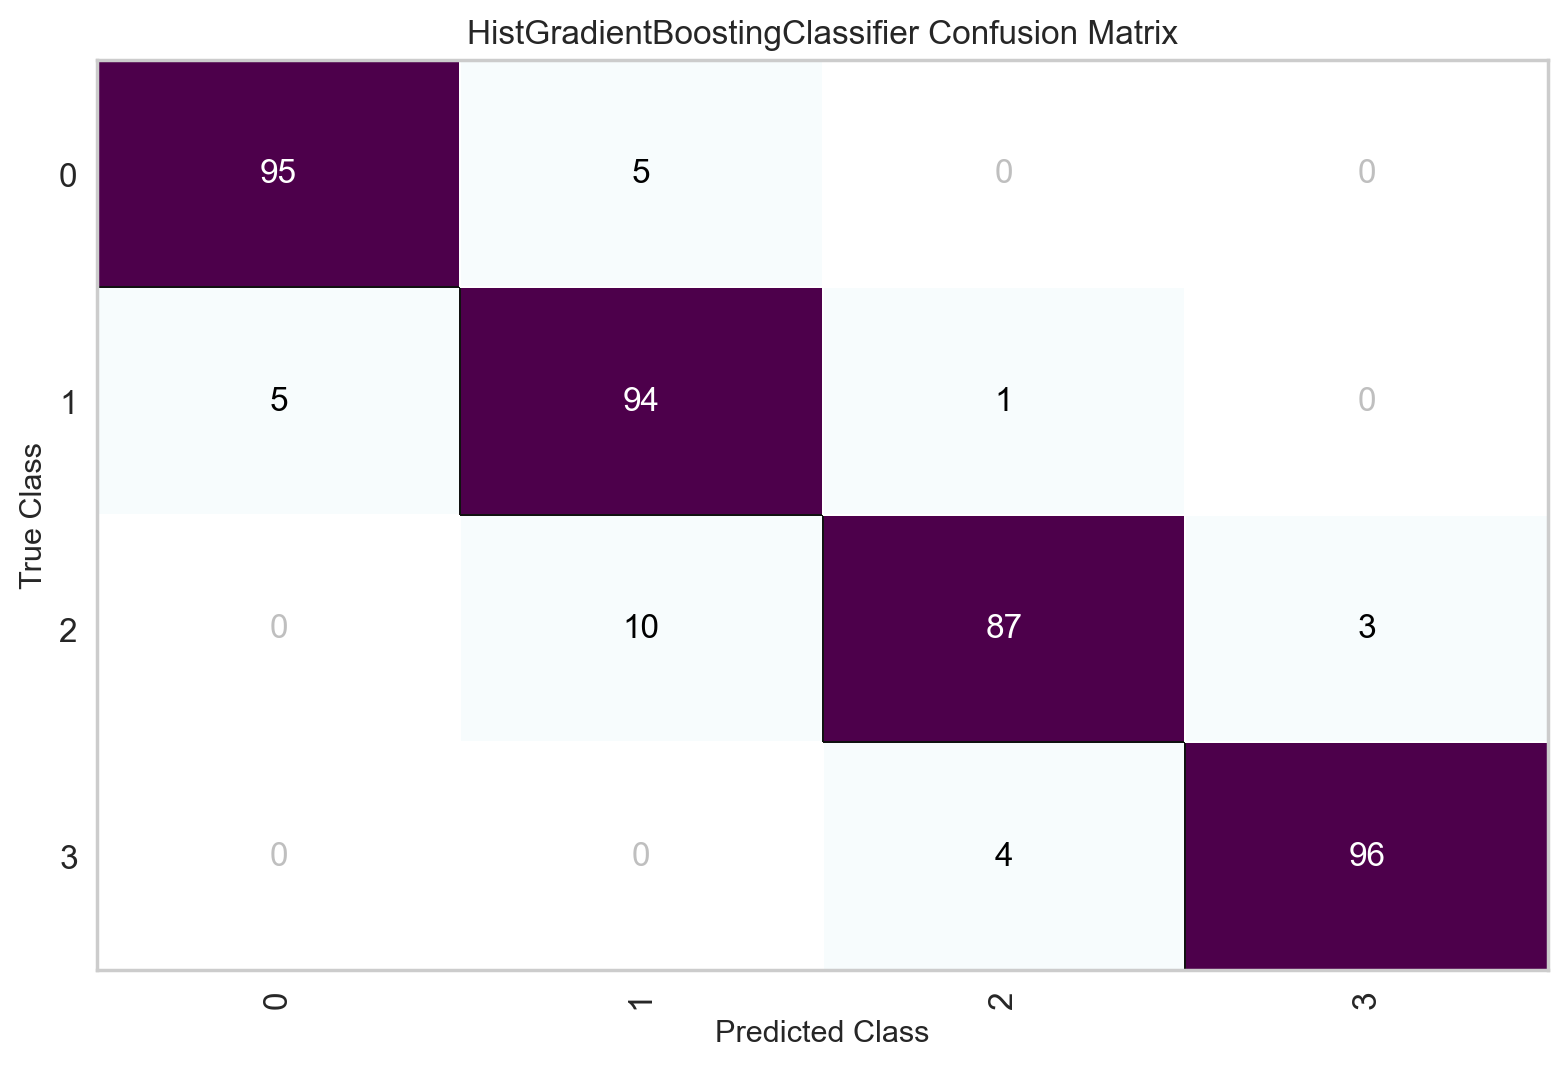

<Axes: title={'center': 'HistGradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
vis_matrix = ConfusionMatrix(hgbc_clf, cmap='BuPu')
vis_matrix.fit(X_train, y_train)
vis_matrix.score(X_val, y_val)
vis_matrix.show()

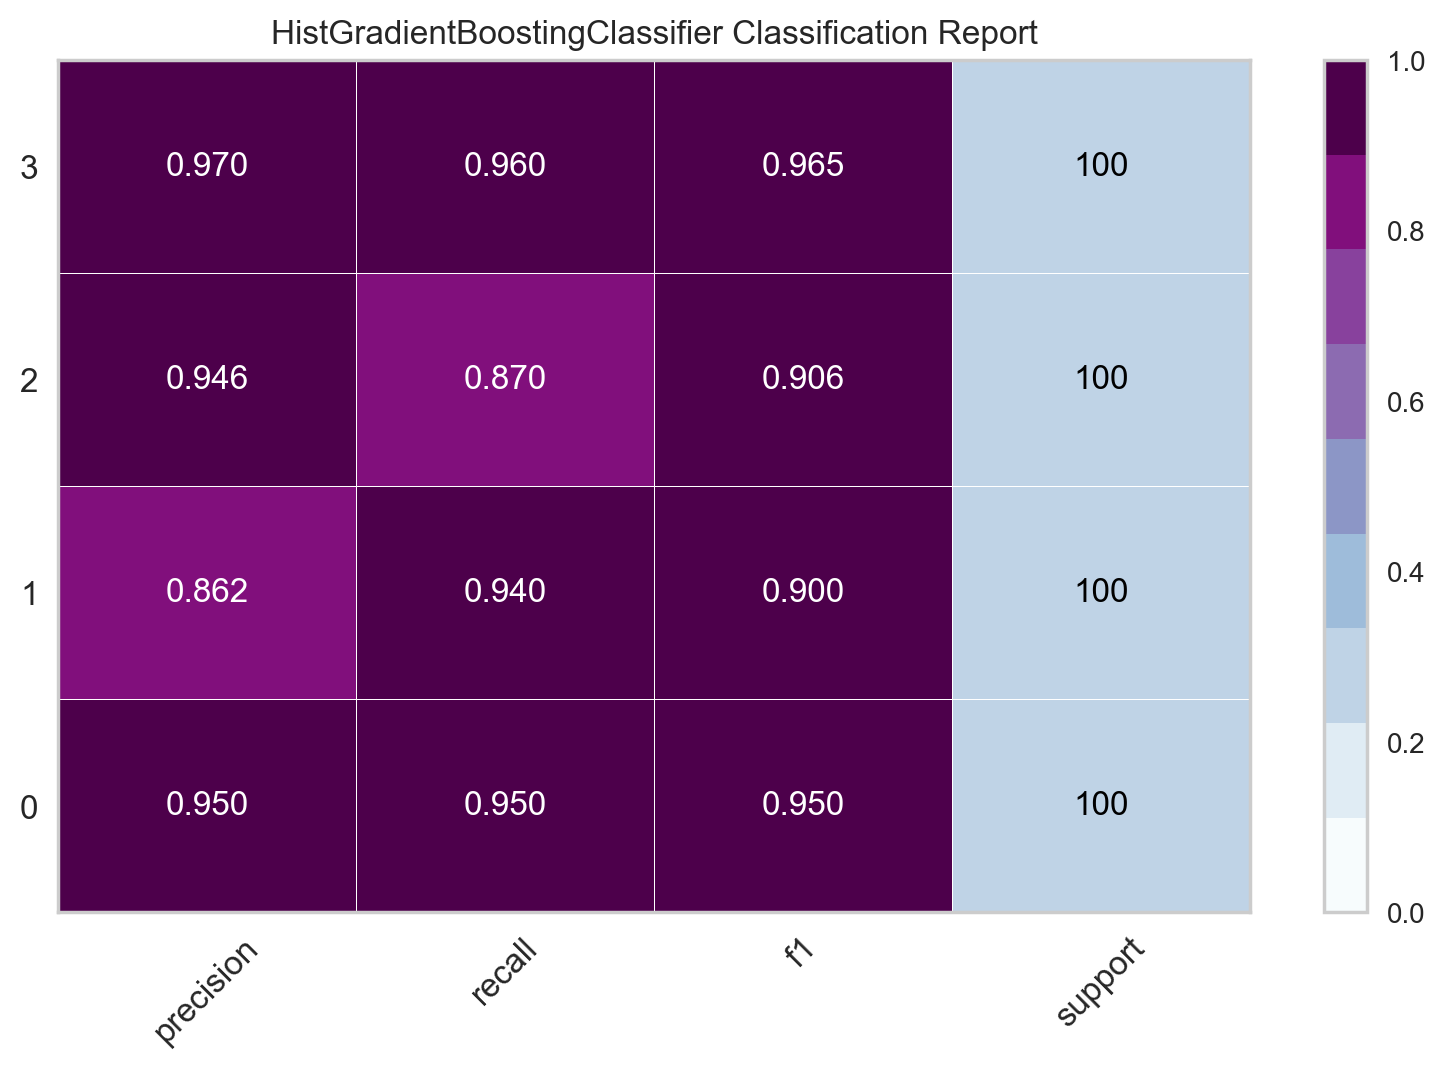

<Axes: title={'center': 'HistGradientBoostingClassifier Classification Report'}>

In [19]:
vis_class = ClassificationReport(hgbc_clf, cmap='BuPu', support=True)
vis_class.fit(X_train, y_train)
vis_class.score(X_val, y_val)
vis_class.show()

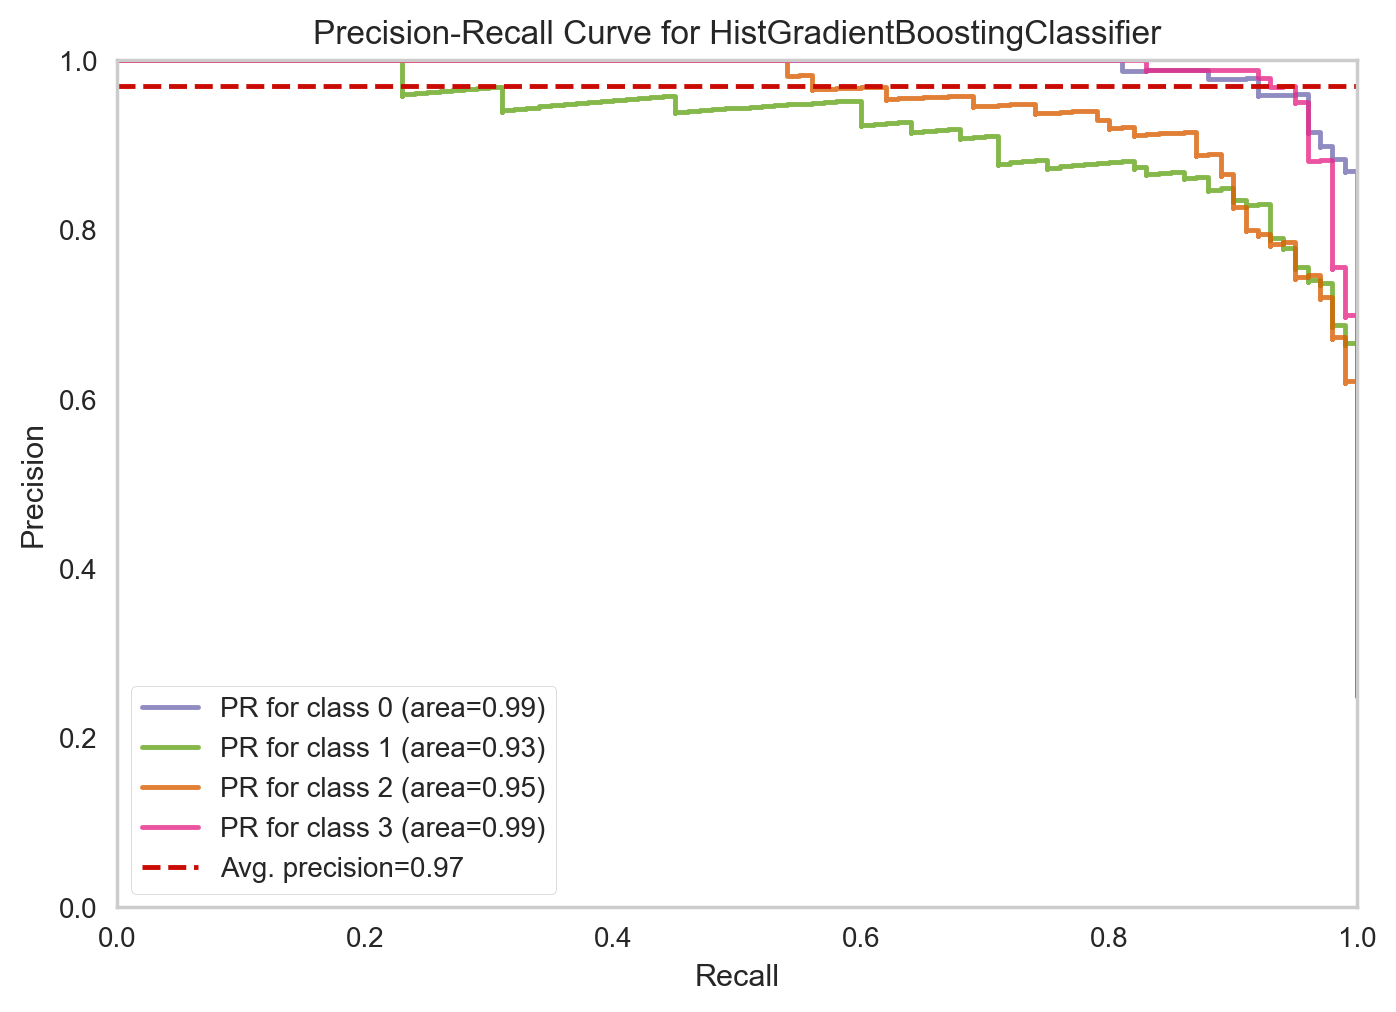

<Axes: title={'center': 'Precision-Recall Curve for HistGradientBoostingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [20]:
vis_prec = PrecisionRecallCurve(hgbc_clf, cmap='dark', micro=False, per_class=True)
vis_prec.fit(X_train, y_train)
vis_prec.score(X_val, y_val)
vis_prec.show()

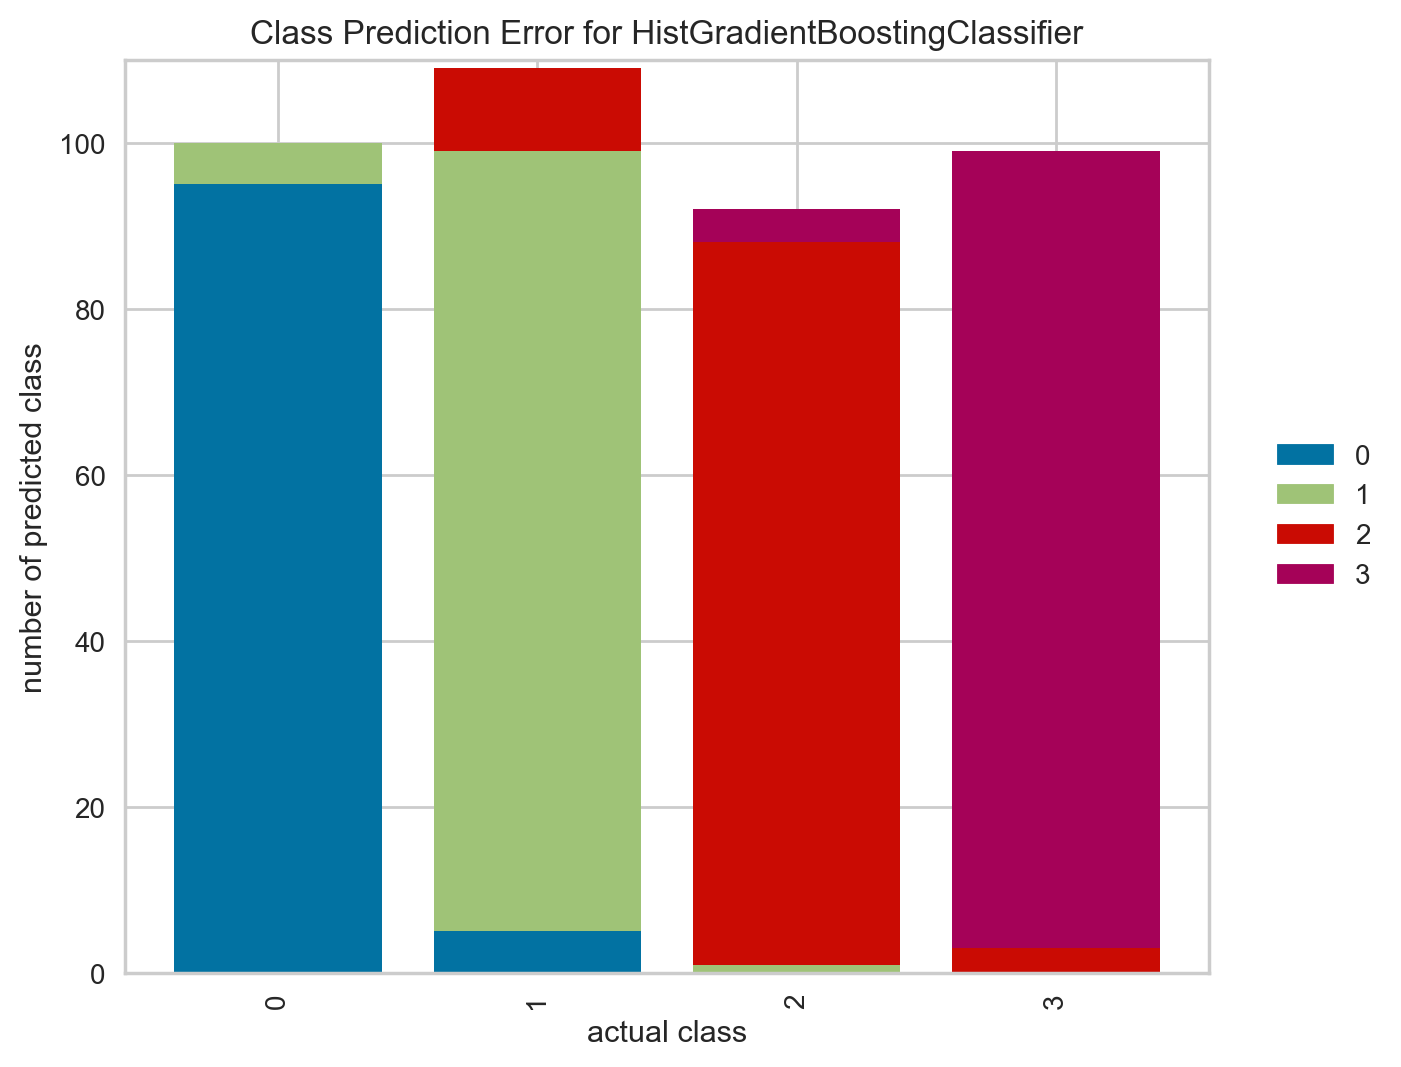

<Axes: title={'center': 'Class Prediction Error for HistGradientBoostingClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [21]:
vis_class_pred = ClassPredictionError(hgbc_clf)
vis_class_pred.fit(X_train, y_train)
vis_class_pred.score(X_val, y_val)
vis_class_pred.show()

In [22]:
from sklearn.ensemble import StackingClassifier

stacked = StackingClassifier(estimators=[('gbc', gbc_clf), ('hgbc', hgbc_clf)],
                             final_estimator=MLPClassifier(solver='sgd', max_iter=20000, activation='tanh'),
                             n_jobs=-1)

stacked

StackingClassifier(estimators=[('gbc',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(n_jobs=-1,
                                                                   remainder=OneHotEncoder(sparse_output=False),
                                                                   transformers=[('pip',
                                                                                  Pipeline(steps=[('log',
                                                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                       func=<ufunc 'log1p'>,
                                                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                                                  ('std',
                                                                                                   StandardScaler())]),
                                                                                  ['battery_power',
                                                                                   'clock_speed',
                                                                                   'fc'...
                                                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                                                  ('std',
                                                                                                   StandardScaler())]),
                                                                                  ['battery_power',
                                                                                   'clock_speed',
                                                                                   'fc',
                                                                                   'int_memory',
                                                                                   'm_dep',
                                                                                   'mobile_wt',
                                                                                   'n_cores',
                                                                                   'px_height',
                                                                                   'px_width',
                                                                                   'ram',
                                                                                   'sc_h',
                                                                                   'sc_w',
                                                                                   'talk_time'])],
                                                                   verbose_feature_names_out=False)),
                                                ('hgbc',
                                                 HistGradientBoostingClassifier())]))],
                   final_estimator=MLPClassifier(activation='tanh',
                                                 max_iter=20000, solver='sgd'),
                   n_jobs=-1)

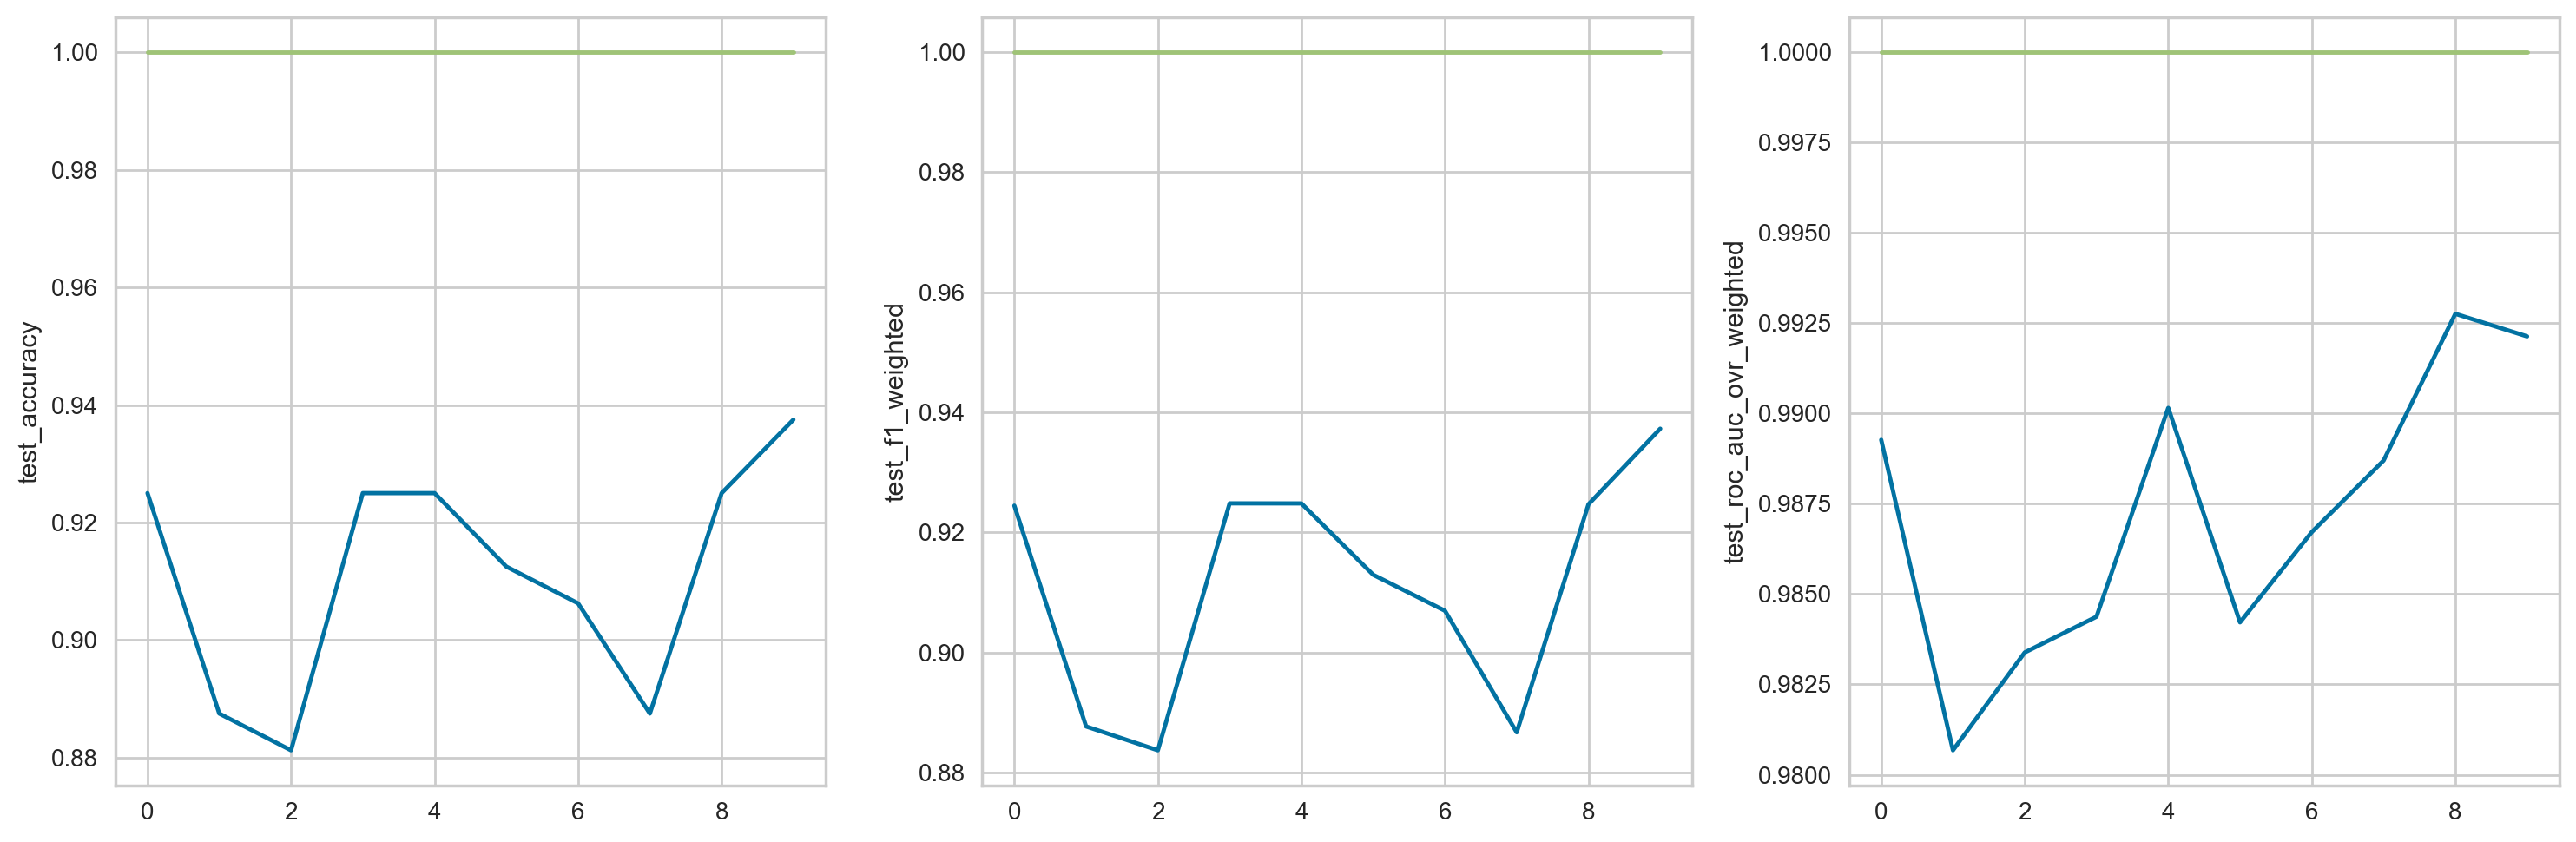

In [23]:
fun_cross_validation(stacked, cv=10)

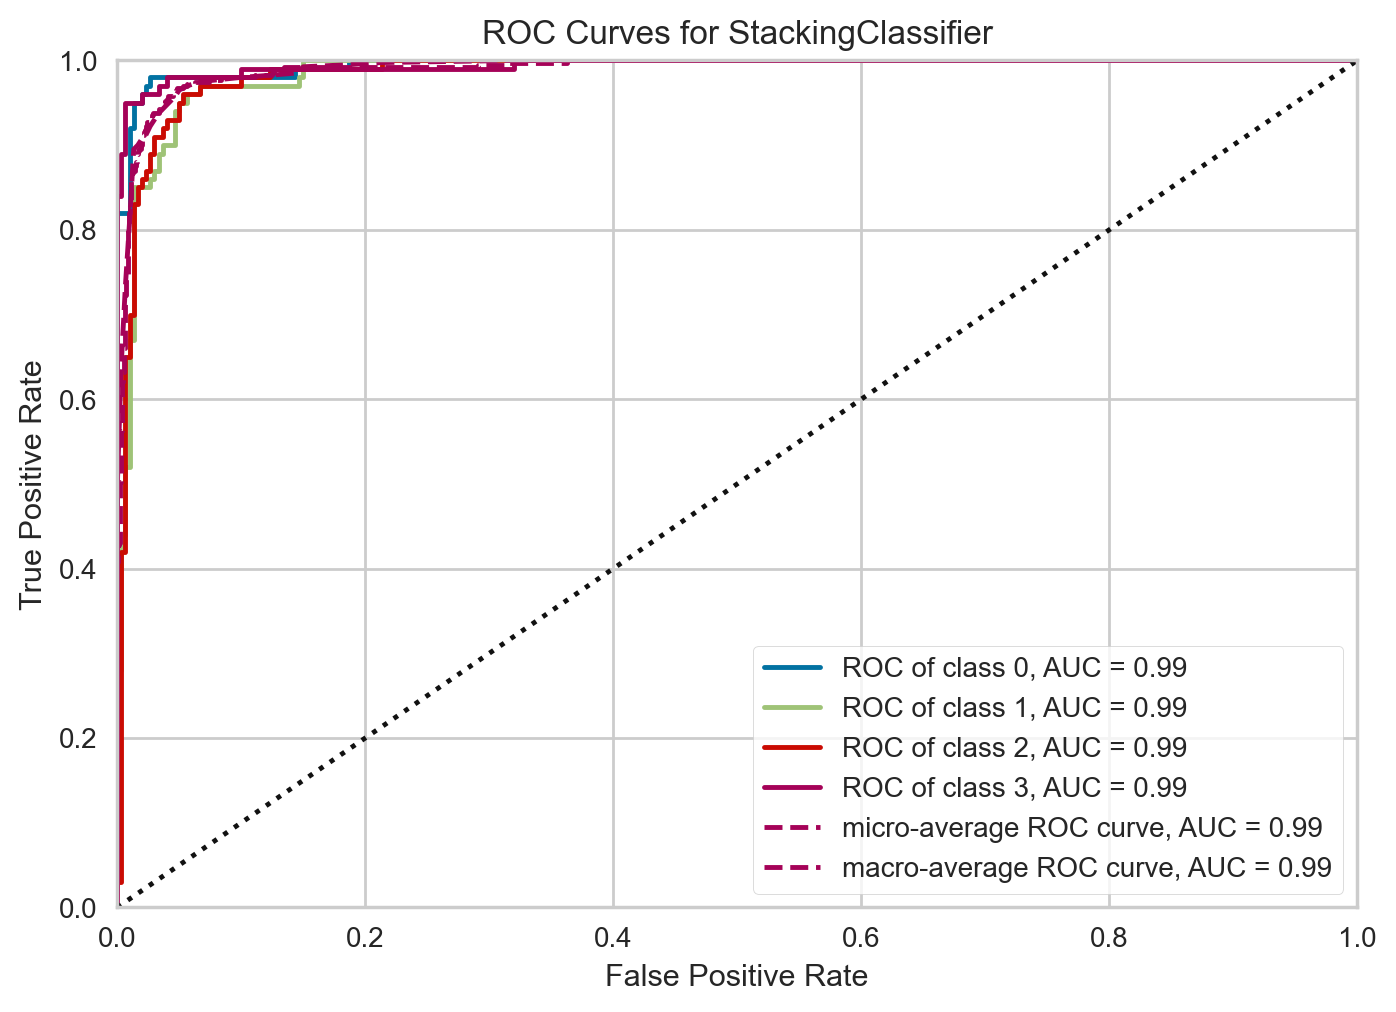

<Axes: title={'center': 'ROC Curves for StackingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
vis_roc = ROCAUC(stacked)

vis_roc.fit(X_train, y_train)
vis_roc.score(X_val, y_val)
vis_roc.show()

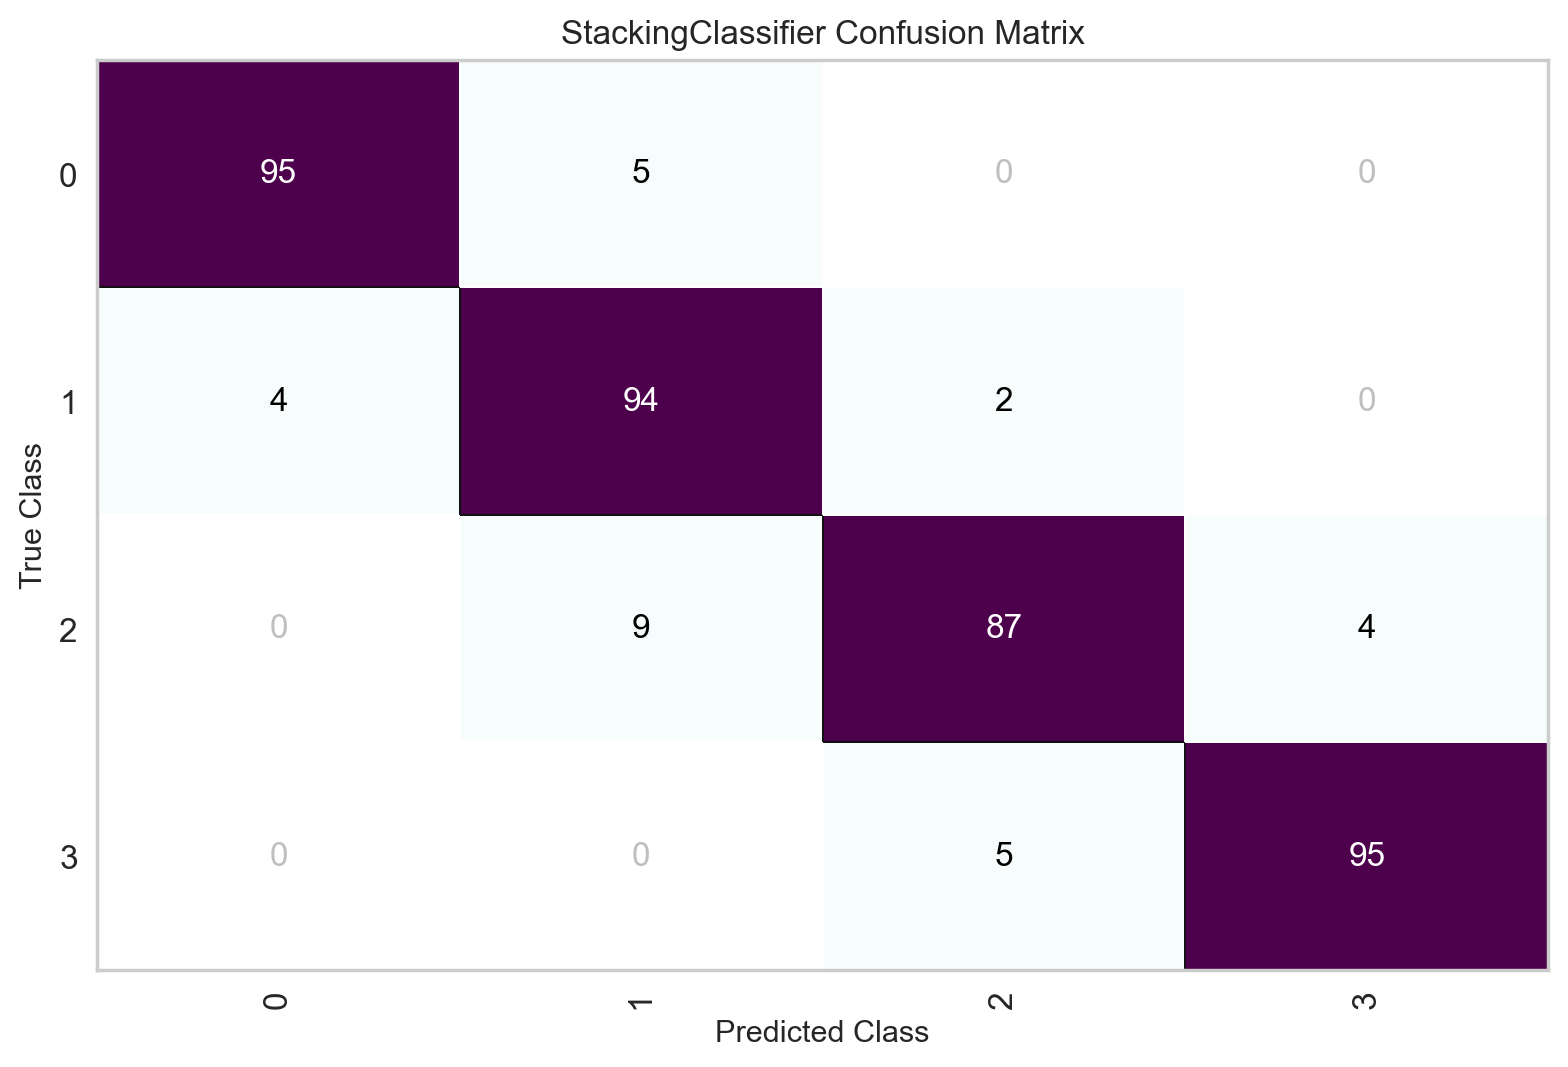

<Axes: title={'center': 'StackingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
vis_matrix = ConfusionMatrix(stacked, cmap='BuPu')
vis_matrix.fit(X_train, y_train)
vis_matrix.score(X_val, y_val)
vis_matrix.show()

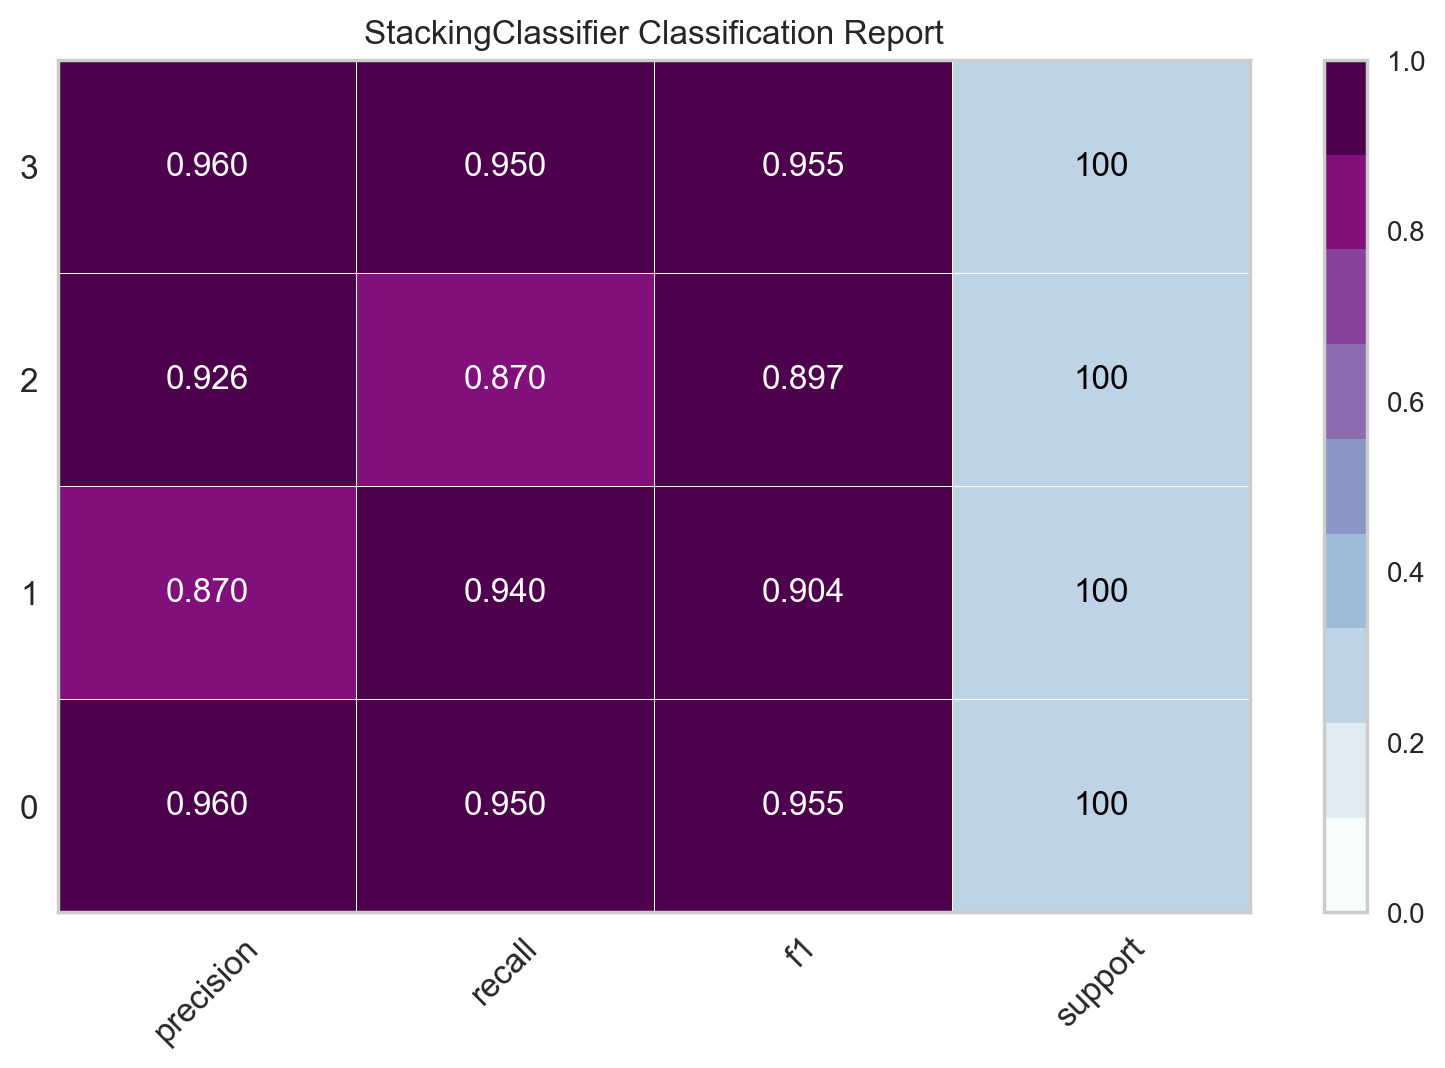

<Axes: title={'center': 'StackingClassifier Classification Report'}>

In [26]:
vis_class = ClassificationReport(stacked, cmap='BuPu', support='count')
vis_class.fit(X_train, y_train)
vis_class.score(X_val, y_val)
vis_class.show()

5551694304

/Users/alejandrodelgado/kaggle_2/new_env/lib/python3.11/site-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


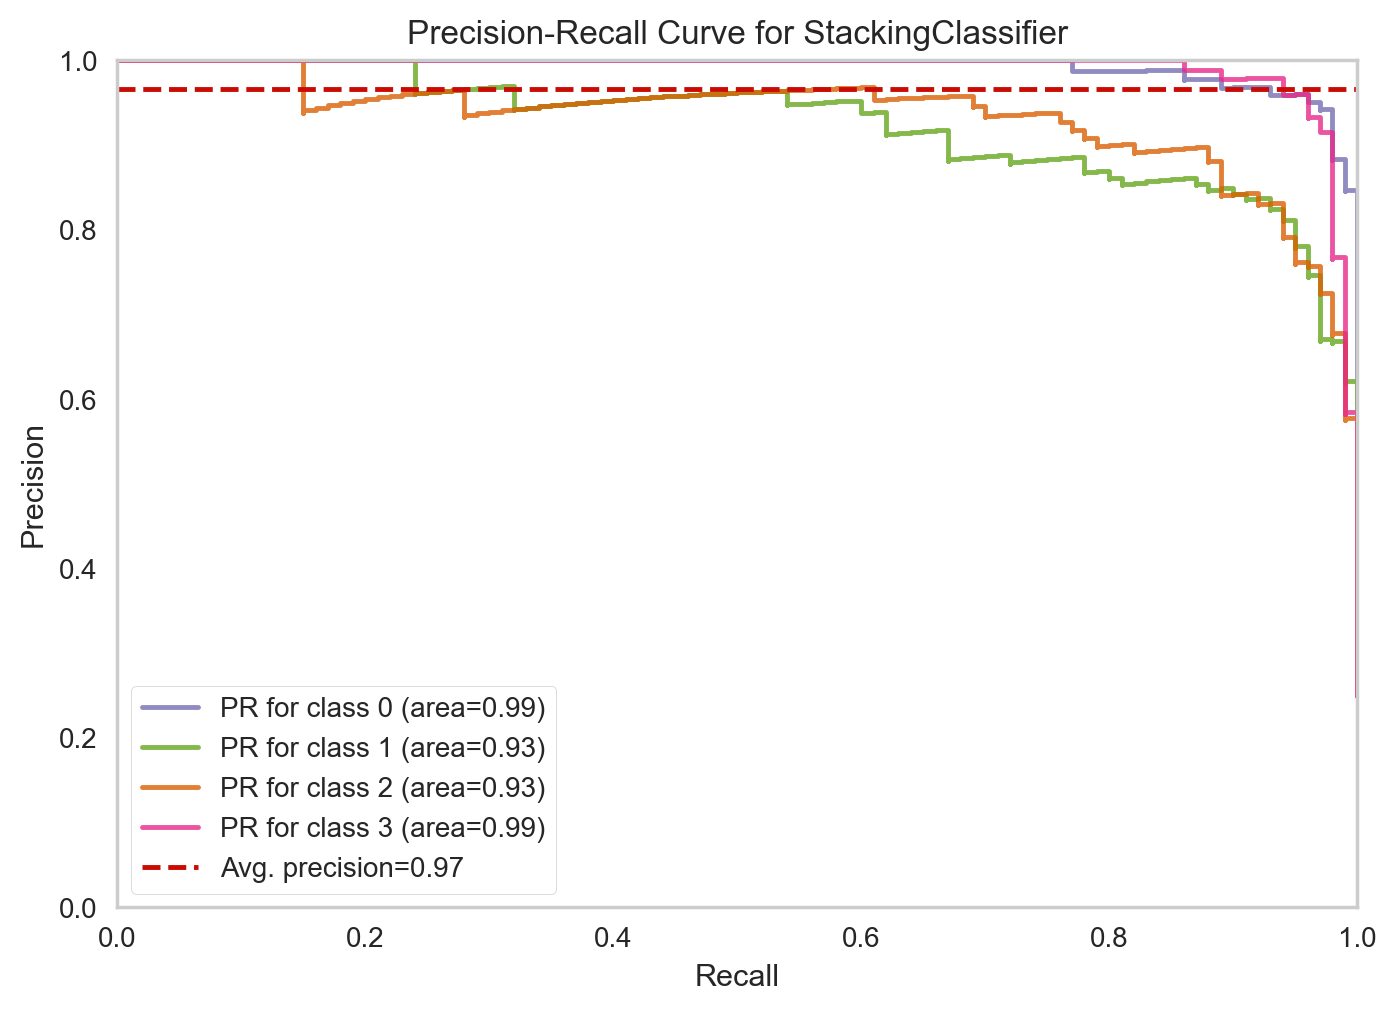

<Axes: title={'center': 'Precision-Recall Curve for StackingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [27]:
vis_prec = PrecisionRecallCurve(stacked, per_class=True, cmap='dark')
vis_prec.fit(X_train, y_train)
vis_prec.score(X_val, y_val)
vis_prec.show()

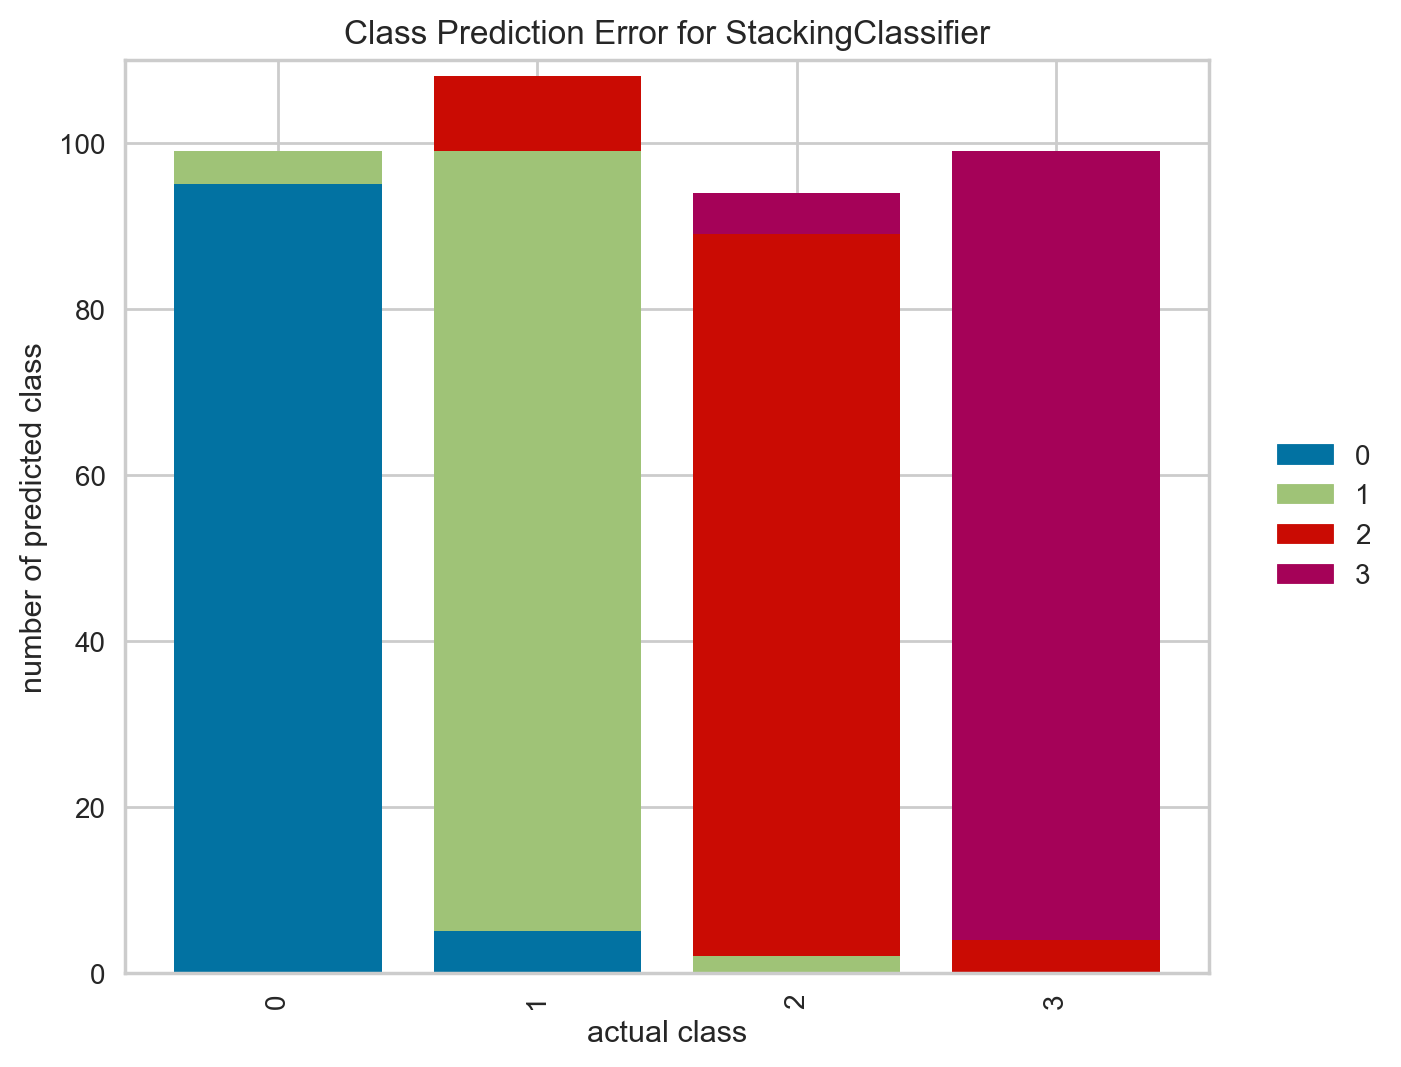

<Axes: title={'center': 'Class Prediction Error for StackingClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [28]:
vis_class_pred = ClassPredictionError(stacked)
vis_class_pred.fit(X_train, y_train)
vis_class_pred.score(X_val, y_val)
vis_class_pred.show()

In [29]:
stacked.fit(X,y)
X_test = test_df.drop('id', axis=1)
test_df['Predicted'] = stacked.predict(X_test)
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,Predicted
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0,3
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1,3
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1,1


In [30]:
submit = test_df[['id', 'Predicted']]
submit.to_csv('submit_5.csv', index=False)

In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm
import copy

In [32]:
X_train_preprocessed = pd.DataFrame(data=preprocessor.fit_transform(X_train),
                                    columns=preprocessor.get_feature_names_out())

X_val_preprocessed = pd.DataFrame(data=preprocessor.fit_transform(X_val),
                                  columns=preprocessor.get_feature_names_out())

test = test_df.drop('id', axis=1)
test_preprocessed = pd.DataFrame(data=preprocessor.fit_transform(test),
                                 columns=preprocessor.get_feature_names_out())

In [33]:
y_train_prenn = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit_transform(y_train.to_numpy().reshape(-1,1))
y_val_prenn = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit_transform(y_val.to_numpy().reshape(-1,1))

In [34]:
if not torch.backends.mps.is_available():
  if not torch.backends.mps.is_built():
    print('MPS not available due to PyTorch')
  else:
    print('MPS not available due to MacOS')

else:
  print('MPS Available!')
  mps_device = torch.device('mps')

MPS Available!


In [35]:
X_train_nn = torch.tensor(X_train_preprocessed.to_numpy(), dtype=torch.float32, device='mps')
X_val_nn = torch.tensor(X_val_preprocessed.to_numpy(), dtype=torch.float32, device='mps')
test_nn = torch.tensor(test_preprocessed.to_numpy(), dtype=torch.float32)

y_train_nn = torch.tensor(y_train_prenn, dtype=torch.float32, device='mps')
y_val_nn = torch.tensor(y_val_prenn, dtype=torch.float32, device='mps')

In [36]:
X_train_preprocessed.shape

(1600, 46)

In [37]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden_1 = nn.Linear(46, 128)
    self.act_1 = nn.ReLU()
    self.hidden_2 = nn.Linear(128,64)
    self.act_2 = nn.ReLU()
    self.output = nn.Linear(64, 4)
    self.soft = nn.Softmax(dim=1)
    

  def forward(self, x):
    return self.soft(self.output(self.act_2(self.hidden_2(self.act_1(self.hidden_1(x))))))

model = Classifier()

In [38]:
import torch.mps
torch.mps.empty_cache()

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.ASGD(model.parameters(), lr=0.1)

n_epochs = 7000
batch_size=1600
batches_per_epoch = len(X_train_nn) // batch_size

best_acc = np.inf
best_weights = None
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

model.to('mps')
for epoch in tqdm.tqdm(range(n_epochs)):
  epoch_loss = []
  epoch_acc = []
  ### Set the model in train mode and run through the batches
  model.train()
  with tqdm.tqdm(range(batches_per_epoch), unit='batch', mininterval=0, disable=True) as bar:
    for i in bar:
      ### Get Batches
      start = i * batch_size
      X_batch = X_train_nn[start:start+batch_size]
      y_batch = y_train_nn[start:start+batch_size]
      ### Forward pass
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      ### Backward pass
      optimiser.zero_grad()
      loss.backward()
      ### Update weights
      optimiser.step()
      ### Compute and store metrics
      acc = (y_pred.round() == y_batch).float().mean()
      epoch_loss.append(float(loss))
      epoch_acc.append(float(acc))
      bar.set_postfix(
        loss=float(loss),
        acc=float(acc)
      )
  
  ### Set model evalutation mode and run through validation set
  model.eval()
  y_pred = model(X_val_nn)
  ce = loss_fn(y_pred, y_val_nn)
  acc = (y_pred.round() == y_val_nn).float().mean()
  ce = float(ce)
  acc = float(acc)
  train_loss_hist.append(np.mean(epoch_loss))
  train_acc_hist.append(np.mean(epoch_acc))
  val_loss_hist.append(ce)
  val_acc_hist.append(acc)
  if acc > best_acc:
    best_acc = acc
    best_weights = copy.deepcopy(model.state_dict())

  if epoch % 1000 == 0:
    print(f'Epoch: {epoch} | Train loss:{np.round(epoch_loss,3)} | Test loss: {np.round(ce,3)} | Train acc: {np.round(epoch_acc,3)} | Test acc: {np.round(acc,3)}')

  0%|          | 18/7000 [00:00<01:39, 70.02it/s]

Epoch: 0 | Train loss:[1.386] | Test loss: 1.386 | Train acc: [0.75] | Test acc: 0.75


 15%|█▍        | 1025/7000 [00:06<00:31, 188.19it/s]

Epoch: 1000 | Train loss:[0.814] | Test loss: 0.858 | Train acc: [0.983] | Test acc: 0.94


 29%|██▉       | 2037/7000 [00:11<00:26, 187.07it/s]

Epoch: 2000 | Train loss:[0.772] | Test loss: 0.835 | Train acc: [0.996] | Test acc: 0.955


 43%|████▎     | 3022/7000 [00:17<00:27, 143.61it/s]

Epoch: 3000 | Train loss:[0.759] | Test loss: 0.826 | Train acc: [0.997] | Test acc: 0.959


 57%|█████▊    | 4025/7000 [00:22<00:15, 186.57it/s]

Epoch: 4000 | Train loss:[0.755] | Test loss: 0.824 | Train acc: [0.997] | Test acc: 0.962


 72%|███████▏  | 5039/7000 [00:28<00:10, 192.69it/s]

Epoch: 5000 | Train loss:[0.753] | Test loss: 0.823 | Train acc: [0.998] | Test acc: 0.961


 86%|████████▌ | 6029/7000 [00:33<00:05, 187.32it/s]

Epoch: 6000 | Train loss:[0.751] | Test loss: 0.823 | Train acc: [0.998] | Test acc: 0.96


100%|██████████| 7000/7000 [00:38<00:00, 180.59it/s]


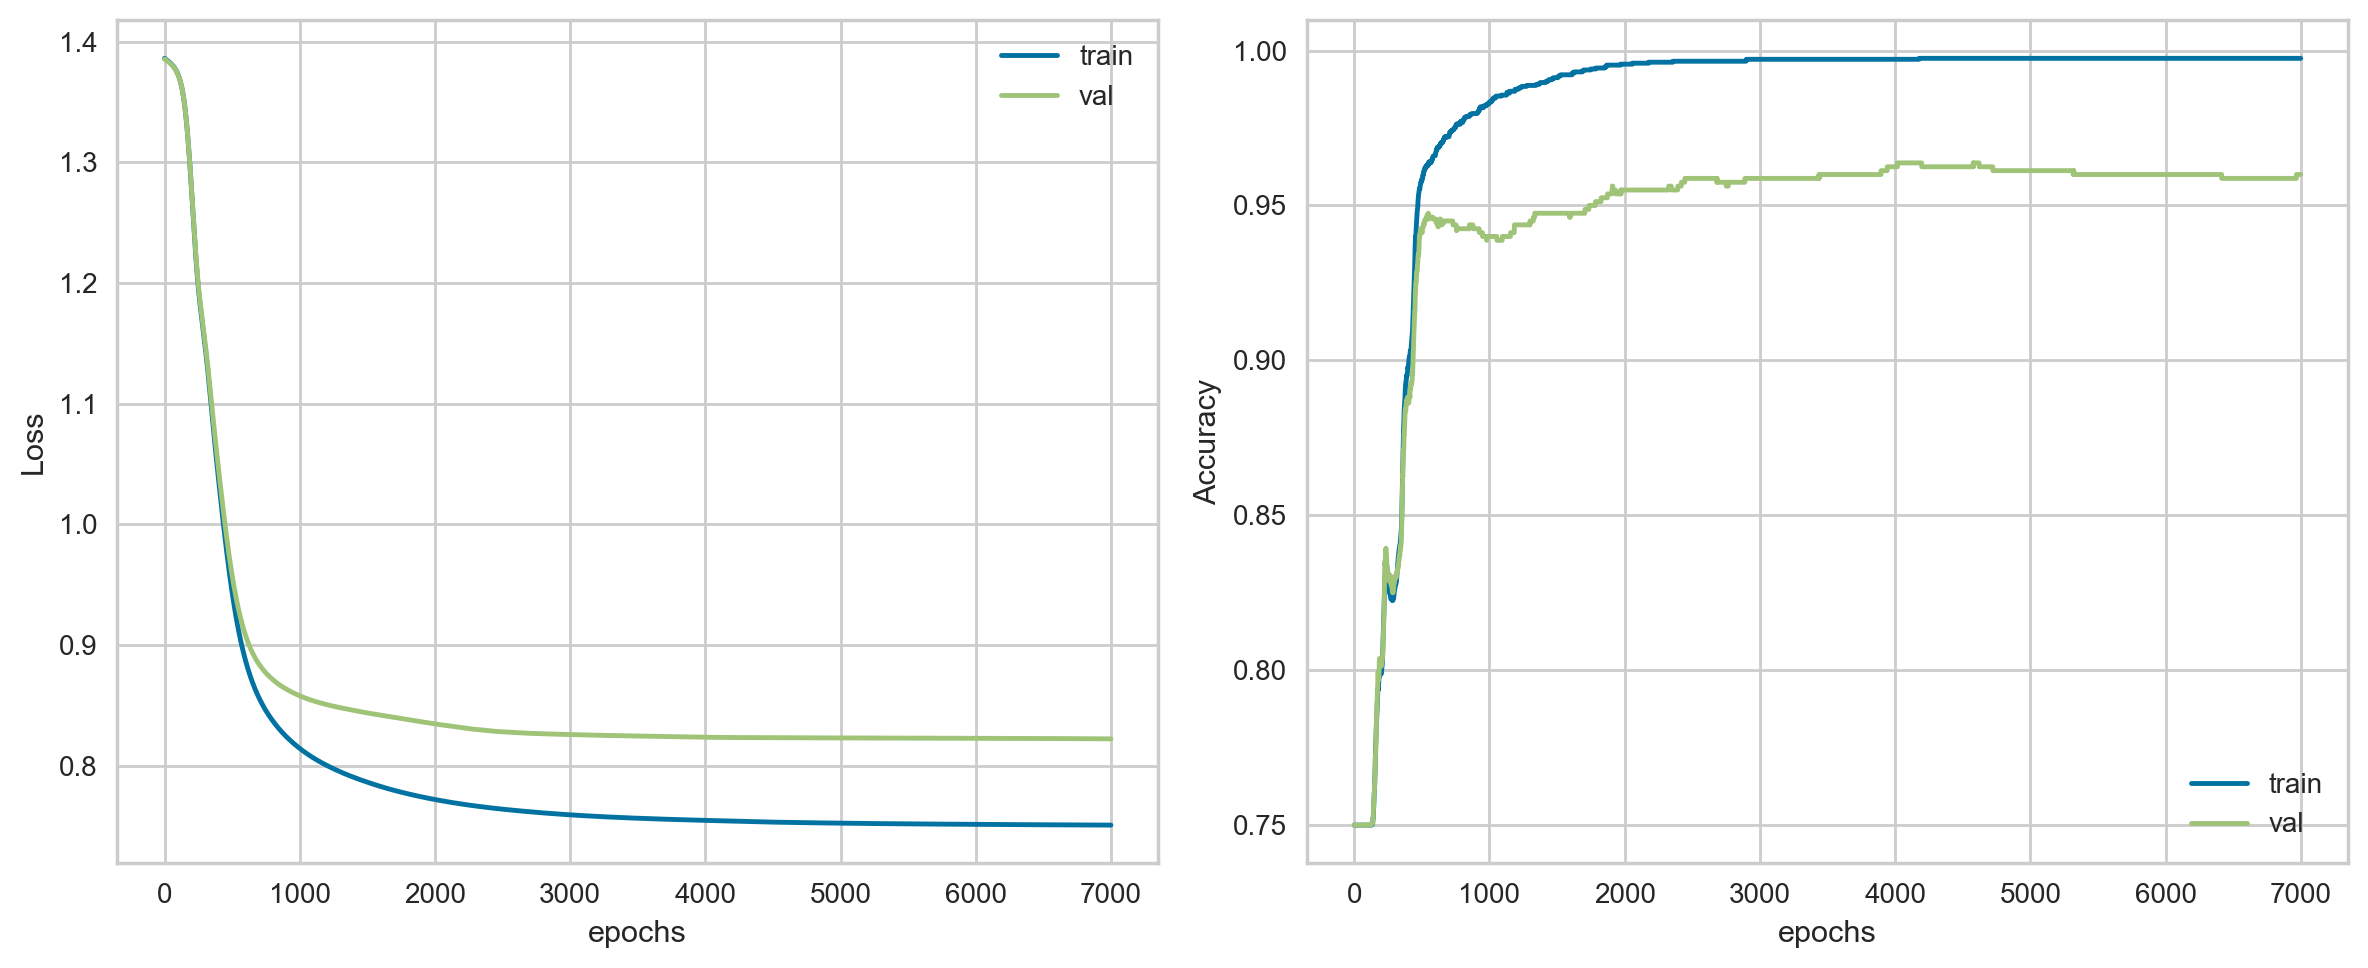

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), tight_layout=True)

axs[0].plot(train_loss_hist, label='train')
axs[0].plot(val_loss_hist, label='val')
axs[1].plot(train_acc_hist, label='train')
axs[1].plot(val_acc_hist, label='val')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('Loss')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('Accuracy')
axs[0].legend()
axs[1].legend()
plt.show()

In [40]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_val_nn)

y_logits[:10]

tensor([[9.9749e-01, 2.5077e-03, 9.7907e-26, 0.0000e+00],
        [7.8318e-11, 5.9786e-01, 4.0214e-01, 2.5389e-13],
        [6.1073e-15, 3.4941e-04, 9.9965e-01, 2.5255e-09],
        [6.1976e-11, 9.9996e-01, 3.9624e-05, 1.3162e-23],
        [6.0821e-05, 9.9994e-01, 2.8151e-13, 0.0000e+00],
        [0.0000e+00, 5.9598e-23, 1.2999e-06, 1.0000e+00],
        [1.3274e-31, 2.2913e-13, 9.4178e-02, 9.0582e-01],
        [2.1141e-19, 2.3375e-06, 1.0000e+00, 1.9816e-06],
        [1.3323e-26, 8.0558e-09, 1.0000e+00, 2.9317e-06],
        [1.0857e-06, 1.0000e+00, 2.3703e-08, 3.8307e-29]], device='mps:0')

In [41]:
y_val_probs = torch.softmax(y_logits, dim=1)
y_val_preds = y_val_probs.argmax(dim=1)

y_preds_val = []
for i in range(len(y_val_preds)):
    y_preds_val.append(y_val_preds[i].item())

X_val['preds'] = y_preds_val
X_val['actual'] = y_val
X_val.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,preds,actual
1093,1403,1,2.5,1,3,0,62,0.9,90,4,13,217,1623,921,14,13,18,1,0,0,0,0
1208,989,1,0.7,0,13,1,51,0.4,132,3,15,670,804,2349,10,1,20,1,0,1,1,1
803,880,0,1.7,0,2,0,6,0.6,198,4,19,632,660,3006,6,4,3,1,0,0,2,2
329,972,1,0.5,1,5,0,13,0.4,193,5,8,1392,1795,1615,11,6,13,0,1,0,1,1
1086,1869,0,2.6,0,0,1,30,0.4,152,1,13,163,874,1375,15,3,19,1,0,0,1,1


In [42]:
acc = accuracy_score(y_true=X_val['actual'], y_pred=X_val['preds'])
f1 = f1_score(y_true=X_val['actual'], y_pred=X_val['preds'], average='weighted')
precision = precision_score(y_true=X_val['actual'], y_pred=X_val['preds'], average='weighted')
recall = recall_score(y_true=X_val['actual'], y_pred=X_val['preds'], average='weighted')
# roc = roc_auc_score(y_true=X_val['actual'], y_score=X_val['preds'], average='weighted', multi_class='ovr')

print(f'Accuracy: {np.round(acc,3)} | F1: {np.round(f1,3)} | Recall {np.round(recall,3)} |')

Accuracy: 0.92 | F1: 0.92 | Recall 0.92 |


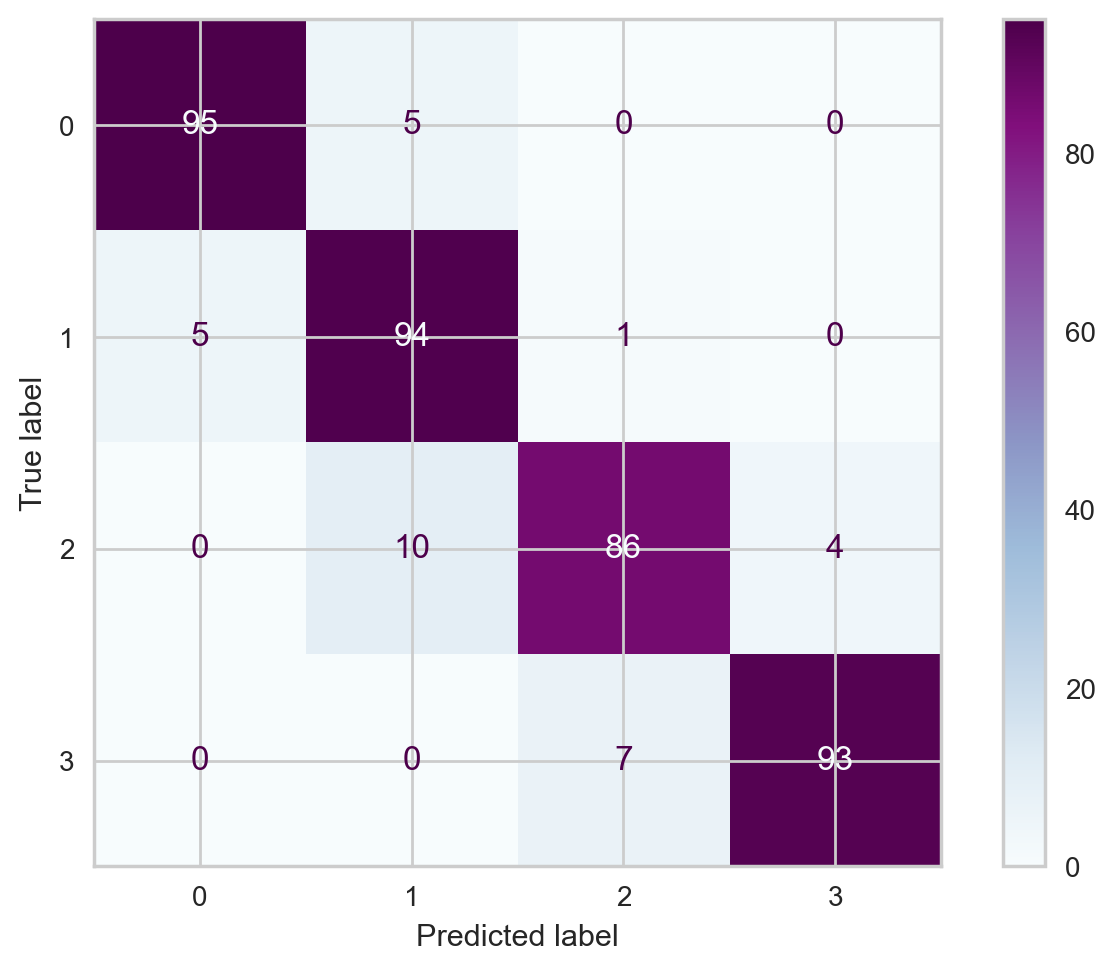

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=X_val['actual'], y_pred=X_val['preds'], cmap='BuPu')
plt.show()

In [49]:
test_preprocessed = test_preprocessed.drop(['Predicted_0', 'Predicted_1', 'Predicted_2', 'Predicted_3'],
                                           axis=1)

In [55]:
test_nn = torch.tensor(test_preprocessed.to_numpy(), dtype=torch.float32, device='mps')

model.to(device='mps')
model.eval()
with torch.inference_mode():
    y_logits = model(test_nn)

y_test_probs = torch.softmax(y_logits, dim=1)
y_test_preds = y_test_probs.argmax(dim=1)

test_preds = []
for i in range(len(y_test_preds)):
    test_preds.append(y_test_preds[i].item())

In [56]:
test_df['Predicted'] = test_preds
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,Predicted
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0,3
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1,2
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1,1


In [57]:
submit_nn = test_df[['id', 'Predicted']]
submit_nn.to_csv('submit_nn.csv', index=False)